In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import StackingClassifier
import tensorflow as tf

import copy
from collections import defaultdict
from scipy.optimize import curve_fit
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [3]:
tf.random.set_seed(42)

In [4]:
seasons = []

for i in range(23):
    num = str(i).zfill(2)
    file_path = f'C:/Users/kamil/OneDrive/Dokumenty/studia/magisterka/data/season_{num}.csv'
    
    header_row = pd.read_csv(file_path, encoding='latin1', nrows=1)
    num_columns = len(header_row.columns)
    
    season = pd.read_csv(file_path, encoding='latin1', usecols=range(num_columns))
    
    print(f"Number of rows in season_{num}: {len(season)}")
    seasons.append(season)

Number of rows in season_00: 380
Number of rows in season_01: 380
Number of rows in season_02: 380
Number of rows in season_03: 380
Number of rows in season_04: 380
Number of rows in season_05: 380
Number of rows in season_06: 380
Number of rows in season_07: 380
Number of rows in season_08: 380
Number of rows in season_09: 380
Number of rows in season_10: 380
Number of rows in season_11: 380
Number of rows in season_12: 380
Number of rows in season_13: 380
Number of rows in season_14: 380
Number of rows in season_15: 380
Number of rows in season_16: 380
Number of rows in season_17: 380
Number of rows in season_18: 380
Number of rows in season_19: 380
Number of rows in season_20: 380
Number of rows in season_21: 380
Number of rows in season_22: 380


In [5]:
selected_columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
                    'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',
                    'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']

df = pd.DataFrame(columns=['season'] + selected_columns)

for i, season_df in enumerate(seasons):
    season_num = f'20{str(i).zfill(2)}'
    season_df_selected = season_df[selected_columns]
    season_df_selected.insert(0, 'season', season_num)
    df = pd.concat([df, season_df_selected], ignore_index=True)
    
df.loc[df['IWH'].isnull(), 'IWH'] = df['WHH']
df.loc[df['IWD'].isnull(), 'IWD'] = df['WHD']
df.loc[df['IWA'].isnull(), 'IWA'] = df['WHA']
        
df.drop(columns=['WHH', 'WHD', 'WHA'], inplace=True)

df = df.rename(columns={
    'Season' : 'season',
    'Date': 'date', 
    'HomeTeam': 'home_team', 
    'AwayTeam': 'away_team',
    'IWH': 'OH',
    'IWD': 'OD',
    'IWA': 'OA'
})    
    
df['season'] = df['season'].astype('int64')
df['FTHG'] = df['FTHG'].astype('int64')
df['FTAG'] = df['FTAG'].astype('int64')
df['FTR'] = df['FTR'].astype('string')
df['HTHG'] = df['HTHG'].astype('int64')
df['HTAG'] = df['HTAG'].astype('int64')
df['HS'] = df['HS'].astype('int64')
df['AS'] = df['AS'].astype('int64')
df['HST'] = df['HST'].astype('int64')
df['AST'] = df['AST'].astype('int64')
df['HC'] = df['HC'].astype('int64')
df['AC'] = df['AC'].astype('int64')
df['HF'] = df['HF'].astype('int64')
df['AF'] = df['AF'].astype('int64')
df['HY'] = df['HY'].astype('int64')
df['AY'] = df['AY'].astype('int64')
df['HR'] = df['HR'].astype('int64')
df['AR'] = df['AR'].astype('int64')

df['date_temp1'] = pd.to_datetime(df['date'], format='%d/%m/%y', errors='coerce')
df['date_temp2'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')
df['date'] = df['date_temp1']
df.loc[df['date'].isnull(), 'date'] = df['date_temp2']
df.drop(columns=['date_temp1', 'date_temp2'], inplace=True)

df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

df

# season - Match Season
# date - Match Date
# home_team - Home Team
# away_team - Away Team
# FTHG - Full Time Home Team Goals
# FTAG - Full Time Away Team Goals
# FTR - Full Time Result (H=Home Win, D=Draw, A=Away Win)
# HTHG - Half Time Home Team Goals
# HTAG - Half Time Away Team Goals
# HTR - Half Time Result (H=Home Win, D=Draw, A=Away Win)
# HS - Home Team Shots
# AS - Away Team Shots
# HST - Home Team Shots on Target
# AST - Away Team Shots on Target
# HC - Home Team Corners
# AC - Away Team Corners
# HF - Home Team Fouls Committed
# AF - Away Team Fouls Committed
# HY - Home Team Yellow Cards
# AY - Away Team Yellow Cards
# HR - Home Team Red Cards
# AR - Away Team Red Cards
# OH - Home Team Win Odds
# OD - Draw Odds
# OA - Away Team Win Odds

season       date    home_team      away_team  FTHG  FTAG FTR  HTHG  \
0       2000 2000-08-19     Charlton       Man City     4     0   H     2   
1       2000 2000-08-19      Chelsea       West Ham     4     2   H     1   
2       2000 2000-08-19     Coventry  Middlesbrough     1     3   A     1   
3       2000 2000-08-19        Derby    Southampton     2     2   D     1   
4       2000 2000-08-19        Leeds        Everton     2     0   H     2   
...      ...        ...          ...            ...   ...   ...  ..   ...   
8735    2022 2023-05-28    Brentford       Man City     1     0   H     0   
8736    2022 2023-05-28  Aston Villa       Brighton     2     1   H     2   
8737    2022 2023-05-28      Arsenal         Wolves     5     0   H     3   
8738    2022 2023-05-28      Chelsea      Newcastle     1     1   D     1   
8739    2022 2023-05-28  Southampton      Liverpool     4     4   D     2   

      HTAG HTR  ...  AC  HF  AF  HY  AY  HR  AR    OH   OD    OA  
0        0   H  ...   6  13  12   1   2   0   0  2.20  2.9  2.70  
1        0   H  ...   7  19  14   1   2   0   0  1.60  3.2  4.20  
2        1   D  ...   4  15  21   5   3   1   0  2.20  2.9  2.70  
3        2   A  ...   8  11  13   1   1   0   0  1.80  3.0  3.50  
4        0   H  ...   4  21  20   1   3   0   0  1.55  3.3  4.50  
...    ...  ..  ...  ..  ..  ..  ..  ..  ..  ..   ...  ...   ...  
8735     0   D  ...   4  12   8   4   0   0   0  3.80  3.9  1.90  
8736     1   H  ...   3  15  16   4   4   0   0  2.00  3.7  3.55  
8737     0   H  ...   4   8  11   0   0   0   0  1.43  4.6  7.75  
8738     1   D  ...   3   9  11   0   0   0   0  2.80  3.5  2.45  
8739     2   D  ...   9   4  10   0   2   0   0  6.25  5.0  1.45  

[8740 rows x 25 columns]

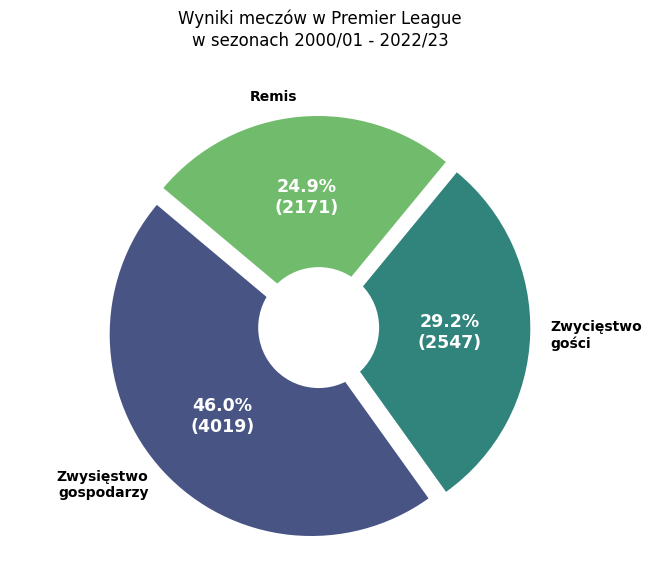

In [6]:
colors = ['#485484', '#30847c', '#70bc6c']

custom_labels = ['Zwysięstwo\ngospodarzy', 'Zwycięstwo\ngości', 'Remis']
explode = (0.05, 0.05, 0.05)

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 6))
ftr_counts = df['FTR'].value_counts()
wedges, texts, autotexts = plt.pie(ftr_counts, explode=explode, labels=custom_labels, autopct=lambda pct: func(pct, ftr_counts), 
                                    startangle=140, colors=colors)
plt.title('Wyniki meczów w Premier League\nw sezonach 2000/01 - 2022/23\n\n')
plt.gca().add_artist(plt.Circle((0,0),0.3,fc='white'))
plt.axis('equal')

for autotext in autotexts:
    autotext.set_color('white')  
    autotext.set_weight('bold')
    autotext.set_fontsize(12.5)
    
for text in texts:
    text.set_weight('bold')

plt.show()

In [7]:
standings = pd.read_csv('C:/Users/kamil/OneDrive/Dokumenty/studia/magisterka/data/standings_2000_2022.csv')

standings['Season'] = standings['Season'].str[:4].astype('int64')
standings['Pos'] = standings['Pos'].astype('int64')

standings = standings[['Season', 'Pos', 'Team']]
standings = standings.rename(
    columns={'Season': 'season', 'Pos': 'position', 'Team': 'team'}
)

standings['team'] = standings['team'].replace('Manchester United', 'Man United')
standings['team'] = standings['team'].replace('Leeds United', 'Leeds')
standings['team'] = standings['team'].replace('Ipswich Town', 'Ipswich')
standings['team'] = standings['team'].replace('Charlton Athletic', 'Charlton')
standings['team'] = standings['team'].replace('Newcastle United', 'Newcastle')
standings['team'] = standings['team'].replace('Tottenham Hotspur', 'Tottenham')
standings['team'] = standings['team'].replace('Leicester City', 'Leicester')
standings['team'] = standings['team'].replace('West Ham United', 'West Ham')
standings['team'] = standings['team'].replace('Derby County', 'Derby')
standings['team'] = standings['team'].replace('Manchester City', 'Man City')
standings['team'] = standings['team'].replace('Coventry City', 'Coventry')
standings['team'] = standings['team'].replace('Bradford City', 'Bradford')
standings['team'] = standings['team'].replace('Blackburn Rovers', 'Blackburn')
standings['team'] = standings['team'].replace('Bolton Wanderers', 'Bolton')
standings['team'] = standings['team'].replace('Birmingham City', 'Birmingham')
standings['team'] = standings['team'].replace('West Bromwich Albion', 'West Brom')
standings['team'] = standings['team'].replace('Wolverhampton Wanderers', 'Wolves')
standings['team'] = standings['team'].replace('Norwich City', 'Norwich')
standings['team'] = standings['team'].replace('Wigan Athletic', 'Wigan')
standings['team'] = standings['team'].replace('Stoke City', 'Stoke')
standings['team'] = standings['team'].replace('Hull City', 'Hull')
standings['team'] = standings['team'].replace('Swansea City', 'Swansea')
standings['team'] = standings['team'].replace('Queens Park Rangers', 'QPR')
standings['team'] = standings['team'].replace('Cardiff City', 'Cardiff')
standings['team'] = standings['team'].replace('Brighton & Hove Albion', 'Brighton')
standings['team'] = standings['team'].replace('Huddersfield Town', 'Huddersfield')
standings['team'] = standings['team'].replace('Hull City', 'Hull')

standings

season  position           team
0      2000         1     Man United
1      2000         2        Arsenal
2      2000         3      Liverpool
3      2000         4          Leeds
4      2000         5        Ipswich
..      ...       ...            ...
455    2022        16  Nott'm Forest
456    2022        17        Everton
457    2022        18      Leicester
458    2022        19          Leeds
459    2022        20    Southampton

[460 rows x 3 columns]

In [8]:
unique_teams = pd.concat([df['home_team'], df['away_team']]).unique()
unique_teams

array(['Charlton', 'Chelsea', 'Coventry', 'Derby', 'Leeds', 'Leicester',
       'Liverpool', 'Sunderland', 'Tottenham', 'Man United', 'Arsenal',
       'Bradford', 'Ipswich', 'Middlesbrough', 'West Ham', 'Southampton',
       'Everton', 'Man City', 'Newcastle', 'Aston Villa', 'Bolton',
       'Blackburn', 'Fulham', 'Birmingham', 'West Brom', 'Portsmouth',
       'Wolves', 'Norwich', 'Crystal Palace', 'Wigan', 'Reading',
       'Sheffield United', 'Watford', 'Hull', 'Stoke', 'Burnley',
       'Blackpool', 'QPR', 'Swansea', 'Cardiff', 'Bournemouth',
       'Brighton', 'Huddersfield', 'Brentford', "Nott'm Forest"],
      dtype=object)

In [9]:
team_matches_dict = {}

for team in unique_teams:
    team_matches = df[df['home_team'].eq(team) | df['away_team'].eq(team)].copy()
    team_matches['team'] = team
    for index, row in team_matches.iterrows():
        if row['home_team'] == team:
            team_matches.at[index, 'opponent'] = row['away_team']
            team_matches.at[index, 'where'] = 'H'
            if row['FTR'] == 'H':
                team_matches.at[index, 'points'] = 3
            elif row['FTR'] == 'D':
                team_matches.at[index, 'points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'points'] = 0
            team_matches.at[index, 'GS'] = row['FTHG']
            team_matches.at[index, 'GC'] = row['FTAG']
            team_matches.at[index, 'S'] = row['HS']
            team_matches.at[index, 'OS'] = row['AS']
            team_matches.at[index, 'ST'] = row['HST']
            team_matches.at[index, 'OST'] = row['AST']
            team_matches.at[index, 'C'] = row['HC']
            team_matches.at[index, 'OC'] = row['AC']
        else:
            team_matches.at[index, 'opponent'] = row['home_team']
            team_matches.at[index, 'where'] = 'A'
            if row['FTR'] == 'H':
                team_matches.at[index, 'points'] = 0
            elif row['FTR'] == 'D':
                team_matches.at[index, 'points'] = 1
            elif row['FTR'] == 'A':
                team_matches.at[index, 'points'] = 3
            team_matches.at[index, 'GS'] = row['FTAG']
            team_matches.at[index, 'GC'] = row['FTHG']
            team_matches.at[index, 'S'] = row['AS']
            team_matches.at[index, 'OS'] = row['HS']
            team_matches.at[index, 'ST'] = row['AST']
            team_matches.at[index, 'OST'] = row['HST']
            team_matches.at[index, 'C'] = row['AC']
            team_matches.at[index, 'OC'] = row['HC']
    int_columns = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
    team_matches[int_columns] = team_matches[int_columns].astype(int)
    team_matches = team_matches.drop(['home_team', 'away_team', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'OH', 'OD', 'OA'],axis=1)
    team_matches_dict[team] = team_matches

In [10]:
for team, matches_df in team_matches_dict.items():
    matches_df['LSP'] = None
    for season, season_df in matches_df.groupby('season'):
        prev_season = season - 1
        if prev_season in standings['season'].unique():
            prev_season_standings = standings[standings['season'] == prev_season]
            team_standings = prev_season_standings[prev_season_standings['team'] == team]
            if not team_standings.empty:
                prev_season_position = team_standings['position'].iloc[0]
                matches_df.loc[matches_df['season'] == season, 'LSP'] = prev_season_position

for team, matches_df in team_matches_dict.items():
    matches_df['LSP'] = matches_df['LSP'].fillna(21).astype(int)
    # 21 dla drużyn które w poprzednim sezonie awansowały do ligi
    
team_matches_dict.get('Man United')

season       date        team     opponent where  points  GS  GC   S  \
9       2000 2000-08-20  Man United    Newcastle     H       3   2   0  19   
12      2000 2000-08-22  Man United      Ipswich     A       1   1   1  15   
27      2000 2000-08-26  Man United     West Ham     A       1   2   2   8   
32      2000 2000-09-05  Man United     Bradford     H       3   6   0  21   
40      2000 2000-09-09  Man United   Sunderland     H       3   3   0  15   
...      ...        ...         ...          ...   ...     ...  ..  ..  ..   
8703    2022 2023-05-07  Man United     West Ham     A       0   0   1  19   
8711    2022 2023-05-13  Man United       Wolves     H       3   2   0  27   
8719    2022 2023-05-20  Man United  Bournemouth     A       3   1   0  20   
8729    2022 2023-05-25  Man United      Chelsea     H       3   4   1  18   
8734    2022 2023-05-28  Man United       Fulham     H       3   2   1  21   

      OS  ST  OST   C  OC  LSP  
9      9   9    6   7   1   21  
12    13   6    8   6   4   21  
27    17   5    8   5   7   21  
32     6  12    4   5   1   21  
40     5   7    1   4   4   21  
...   ..  ..  ...  ..  ..  ...  
8703  15   4    4   6   5    6  
8711   5   9    0  11   7    6  
8719  10   5    4   6   3    6  
8729  14   9    5   3   4    6  
8734  10   8    3   5   4    6  

[874 rows x 15 columns]

In [11]:
def rolling_averages(team, cols, new_cols, number_of_games):
    team_df = team_matches_dict.get(team).sort_values('date')
    rolling_stats = team_df[cols].rolling(number_of_games, closed='left').mean()
    team_df[new_cols] = rolling_stats.values
    team_matches_dict[team] = team_df

    
cols = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
new_cols = [f'{c}_rolling' for c in cols]

for team in unique_teams:
    rolling_averages(team, cols, new_cols, 5)
    
team_matches_dict.get('Man United')

season       date        team     opponent where  points  GS  GC   S  \
9       2000 2000-08-20  Man United    Newcastle     H       3   2   0  19   
12      2000 2000-08-22  Man United      Ipswich     A       1   1   1  15   
27      2000 2000-08-26  Man United     West Ham     A       1   2   2   8   
32      2000 2000-09-05  Man United     Bradford     H       3   6   0  21   
40      2000 2000-09-09  Man United   Sunderland     H       3   3   0  15   
...      ...        ...         ...          ...   ...     ...  ..  ..  ..   
8703    2022 2023-05-07  Man United     West Ham     A       0   0   1  19   
8711    2022 2023-05-13  Man United       Wolves     H       3   2   0  27   
8719    2022 2023-05-20  Man United  Bournemouth     A       3   1   0  20   
8729    2022 2023-05-25  Man United      Chelsea     H       3   4   1  18   
8734    2022 2023-05-28  Man United       Fulham     H       3   2   1  21   

      OS  ...  LSP  points_rolling  GS_rolling  GC_rolling  S_rolling  \
9      9  ...   21             NaN         NaN         NaN        NaN   
12    13  ...   21             NaN         NaN         NaN        NaN   
27    17  ...   21             NaN         NaN         NaN        NaN   
32     6  ...   21             NaN         NaN         NaN        NaN   
40     5  ...   21             NaN         NaN         NaN        NaN   
...   ..  ...  ...             ...         ...         ...        ...   
8703  15  ...    6             2.0         1.4         0.6       19.6   
8711   5  ...    6             1.4         1.0         0.8       17.6   
8719  10  ...    6             1.4         1.0         0.8       18.6   
8729  14  ...    6             1.8         0.8         0.4       19.2   
8734  10  ...    6             1.8         1.4         0.6       20.0   

      OS_rolling  ST_rolling  OST_rolling  C_rolling  OC_rolling  
9            NaN         NaN          NaN        NaN         NaN  
12           NaN         NaN          NaN        NaN         NaN  
27           NaN         NaN          NaN        NaN         NaN  
32           NaN         NaN          NaN        NaN         NaN  
40           NaN         NaN          NaN        NaN         NaN  
...          ...         ...          ...        ...         ...  
8703        13.6         7.6          3.0        6.8         5.2  
8711        13.6         6.2          3.6        6.0         5.4  
8719        13.4         6.4          3.6        6.4         6.0  
8729        11.8         5.8          3.0        6.0         5.4  
8734        13.2         6.4          3.8        6.4         5.4  

[874 rows x 24 columns]

In [12]:
cols = ['points_rolling', 'GS_rolling', 'GC_rolling', 'S_rolling', 
        'OS_rolling', 'ST_rolling', 'OST_rolling', 'C_rolling', 'OC_rolling', 'LSP']

new_cols_home = [f'home_team_{c}' for c in cols]
new_cols_away = [f'away_team_{c}' for c in cols]

for index, row in df.iterrows():
    for i in range(len(cols)):
        df.at[index, new_cols_home[i]] = team_matches_dict.get(row['home_team'])[cols[i]].loc[index]
        df.at[index, new_cols_away[i]] = team_matches_dict.get(row['away_team'])[cols[i]].loc[index]
    
df.dropna(axis=0, how='any', inplace=True)

df['home_team_LSP'] = df['home_team_LSP'].astype('int64')
df['away_team_LSP'] = df['away_team_LSP'].astype('int64')

df = df[df['season'] != 2000]

df.head()


season       date      home_team    away_team  FTHG  FTAG FTR  HTHG  \
380    2001 2001-08-18       Charlton      Everton     1     2   A     0   
382    2001 2001-08-18          Leeds  Southampton     2     0   H     0   
384    2001 2001-08-18      Liverpool     West Ham     2     1   H     1   
385    2001 2001-08-18  Middlesbrough      Arsenal     0     4   A     0   
386    2001 2001-08-18     Sunderland      Ipswich     1     0   H     1   

     HTAG HTR  ...  home_team_ST_rolling  away_team_ST_rolling  \
380     0   D  ...                   6.2                   5.8   
382     0   D  ...                   7.8                   4.2   
384     1   D  ...                   8.6                   8.0   
385     1   A  ...                   5.4                   5.4   
386     0   H  ...                   6.2                   5.8   

     home_team_OST_rolling  away_team_OST_rolling  home_team_C_rolling  \
380                    8.0                    5.4                  5.0   
382                    6.2                    6.2                  7.2   
384                    5.6                    8.0                  5.0   
385                    5.2                    3.2                  5.0   
386                    6.8                    3.8                  4.6   

     away_team_C_rolling  home_team_OC_rolling  away_team_OC_rolling  \
380                  3.6                   9.6                   6.2   
382                  5.0                   6.2                   4.0   
384                  6.4                   6.6                   5.8   
385                  8.0                   6.8                   3.4   
386                  7.8                   7.0                   3.0   

     home_team_LSP  away_team_LSP  
380              9             16  
382              4             10  
384              3             15  
385             14              2  
386              7              5  

[5 rows x 45 columns]

In [13]:
df['season'].value_counts().sort_index(ascending=True)

season
2001    365
2002    370
2003    371
2004    371
2005    375
2006    366
2007    380
2008    370
2009    375
2010    375
2011    370
2012    380
2013    375
2014    380
2015    375
2016    380
2017    370
2018    380
2019    380
2020    380
2021    375
2022    375
Name: count, dtype: int64

In [14]:
df['home_team_code'] = df['home_team'].astype('category').cat.codes
df['away_team_code'] = df['away_team'].astype('category').cat.codes

team_names = {
    code: name for code, name in zip(df['home_team_code'], df['home_team'])
}
team_names.update({
    code: name for code, name in zip(df['away_team_code'], df['away_team'])
})

team_names

{11: 'Charlton',
 20: 'Leeds',
 22: 'Liverpool',
 25: 'Middlesbrough',
 35: 'Sunderland',
 37: 'Tottenham',
 12: 'Chelsea',
 15: 'Everton',
 19: 'Ipswich',
 0: 'Arsenal',
 33: 'Southampton',
 40: 'West Ham',
 1: 'Aston Villa',
 26: 'Newcastle',
 24: 'Man United',
 21: 'Leicester',
 14: 'Derby',
 3: 'Blackburn',
 5: 'Bolton',
 16: 'Fulham',
 23: 'Man City',
 39: 'West Brom',
 2: 'Birmingham',
 29: 'Portsmouth',
 42: 'Wolves',
 13: 'Crystal Palace',
 27: 'Norwich',
 41: 'Wigan',
 31: 'Reading',
 32: 'Sheffield United',
 38: 'Watford',
 34: 'Stoke',
 18: 'Hull',
 9: 'Burnley',
 4: 'Blackpool',
 30: 'QPR',
 36: 'Swansea',
 10: 'Cardiff',
 6: 'Bournemouth',
 8: 'Brighton',
 17: 'Huddersfield',
 7: 'Brentford',
 28: "Nott'm Forest"}

In [15]:
cols = ['points', 'GS', 'GC', 'S', 'OS', 'ST', 'OST', 'C', 'OC']
for col in cols:
    df[f'{col}_difference'] = df[f'home_team_{col}_rolling'] - df[f'away_team_{col}_rolling']
    
df['LSP_difference'] = df[f'home_team_LSP'] - df[f'away_team_LSP']
    
df['target'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

df.head()

season       date      home_team    away_team  FTHG  FTAG FTR  HTHG  \
380    2001 2001-08-18       Charlton      Everton     1     2   A     0   
382    2001 2001-08-18          Leeds  Southampton     2     0   H     0   
384    2001 2001-08-18      Liverpool     West Ham     2     1   H     1   
385    2001 2001-08-18  Middlesbrough      Arsenal     0     4   A     0   
386    2001 2001-08-18     Sunderland      Ipswich     1     0   H     1   

     HTAG HTR  ...  GS_difference  GC_difference  S_difference  OS_difference  \
380     0   D  ...            0.0           -0.2          -0.8            3.8   
382     0   D  ...            1.6           -0.8           3.0            0.8   
384     1   D  ...            1.6           -1.0           0.2           -4.2   
385     1   A  ...           -0.6            0.0           4.6            4.0   
386     0   H  ...           -0.2            0.2          -2.8            6.2   

     ST_difference  OST_difference  C_difference  OC_difference  \
380            0.4             2.6           1.4            3.4   
382            3.6             0.0           2.2            2.2   
384            0.6            -2.4          -1.4            0.8   
385            0.0             2.0          -3.0            3.4   
386            0.4             3.0          -3.2            4.0   

     LSP_difference  target  
380              -7       2  
382              -6       0  
384             -12       0  
385              12       2  
386               2       0  

[5 rows x 58 columns]

In [16]:
train = df[(df['season'] >= 2010) & (df['season'] <= 2015)]

train

season       date    home_team    away_team  FTHG  FTAG FTR  HTHG  HTAG  \
3800    2010 2010-08-14  Aston Villa     West Ham     3     0   H     2     0   
3801    2010 2010-08-14    Blackburn      Everton     1     0   H     1     0   
3802    2010 2010-08-14       Bolton       Fulham     0     0   D     0     0   
3803    2010 2010-08-14      Chelsea    West Brom     6     0   H     2     0   
3804    2010 2010-08-14   Sunderland   Birmingham     2     2   D     1     0   
...      ...        ...          ...          ...   ...   ...  ..   ...   ...   
6075    2015 2016-05-15    Newcastle    Tottenham     5     1   H     2     0   
6076    2015 2016-05-15      Everton      Norwich     3     0   H     2     0   
6077    2015 2016-05-15      Chelsea    Leicester     1     1   D     0     0   
6078    2015 2016-05-15      Arsenal  Aston Villa     4     0   H     1     0   
6079    2015 2016-05-17   Man United  Bournemouth     3     1   H     1     0   

     HTR  ...  GS_difference  GC_difference  S_difference  OS_difference  \
3800   H  ...           -0.2           -0.8           3.0            2.4   
3801   H  ...           -0.4            0.0          -3.2            1.0   
3802   D  ...            0.4           -0.6           3.6            5.8   
3803   H  ...            2.6           -0.4           5.2           -4.2   
3804   H  ...            0.0           -0.8           0.4           -0.6   
...   ..  ...            ...            ...           ...            ...   
6075   H  ...           -0.8           -0.4         -10.4           -2.4   
6076   H  ...            0.0            0.8          -4.4           11.0   
6077   D  ...           -0.6            1.2          -5.0            2.0   
6078   H  ...            0.2           -1.4           7.6           -3.2   
6079   H  ...            0.2           -1.2          -0.6           -2.2   

      ST_difference  OST_difference  C_difference  OC_difference  \
3800            2.0             3.4           4.6            1.6   
3801           -2.0            -0.4          -3.4            2.2   
3802            2.8             1.6          -0.4            0.6   
3803            3.0            -2.8          -3.0            0.6   
3804           -0.6             0.2          -0.6           -2.2   
...             ...             ...           ...            ...   
6075           -1.4             0.0          -2.2           -1.0   
6076           -0.6             2.8          -2.2            3.4   
6077           -0.2             2.6           0.6            1.8   
6078            2.8            -2.2           2.4           -3.6   
6079            1.2            -1.6           1.0           -0.6   

      LSP_difference  target  
3800             -11       0  
3801               2       0  
3802               2       1  
3803             -20       0  
3804               4       1  
...              ...     ...  
6075              10       0  
6076             -10       0  
6077             -13       1  
6078             -14       0  
6079             -17       0  

[2255 rows x 58 columns]

In [17]:
test = df[df['season'] == 2016]

test

season       date       home_team       away_team  FTHG  FTAG FTR  HTHG  \
6080    2016 2016-08-13     Southampton         Watford     1     1   D     0   
6081    2016 2016-08-13   Middlesbrough           Stoke     1     1   D     1   
6082    2016 2016-08-13            Hull       Leicester     2     1   H     1   
6083    2016 2016-08-13        Man City      Sunderland     2     1   H     1   
6084    2016 2016-08-13  Crystal Palace       West Brom     0     1   A     0   
...      ...        ...             ...             ...   ...   ...  ..   ...   
6455    2016 2017-05-21       Liverpool   Middlesbrough     3     0   H     1   
6456    2016 2017-05-21      Man United  Crystal Palace     2     0   H     2   
6457    2016 2017-05-21     Southampton           Stoke     0     1   A     0   
6458    2016 2017-05-21         Swansea       West Brom     2     1   H     0   
6459    2016 2017-05-21         Watford        Man City     0     5   A     0   

      HTAG HTR  ...  GS_difference  GC_difference  S_difference  \
6080     1   A  ...            1.4           -1.2           1.0   
6081     0   H  ...           -0.2           -0.4          -0.4   
6082     0   H  ...           -1.8            0.2          -4.4   
6083     0   H  ...            0.2            0.6          -0.6   
6084     0   D  ...            0.2            0.2          -2.0   
...    ...  ..  ...            ...            ...           ...   
6455     0   H  ...            0.6           -1.8           8.6   
6456     0   H  ...           -0.8           -0.8          -0.2   
6457     0   D  ...           -0.8           -1.2          -1.2   
6458     1   A  ...            0.6           -1.2           0.2   
6459     4   A  ...           -1.8            1.4          -9.2   

      OS_difference  ST_difference  OST_difference  C_difference  \
6080           -0.6           -0.2             0.0           1.4   
6081           -3.2            2.4             2.0          -0.4   
6082           -3.2           -2.2             0.8           1.0   
6083           -7.2            0.0            -3.0          -0.4   
6084            3.0           -0.2             1.6          -1.4   
...             ...            ...             ...           ...   
6455          -10.0            3.2            -3.8           1.0   
6456           -1.0           -0.2             1.4          -0.2   
6457            0.8           -0.6            -0.8           0.8   
6458           -4.6            1.6             0.0           1.0   
6459            6.8           -4.2             3.2          -4.2   

      OC_difference  LSP_difference  target  
6080            0.2              -7       1  
6081            0.0              12       1  
6082           -1.2              20       0  
6083           -0.2             -13       0  
6084            0.4               1       2  
...             ...             ...     ...  
6455           -2.2             -13       0  
6456           -1.2             -10       0  
6457           -0.8              -3       2  
6458           -0.4              -2       0  
6459            4.2               9       2  

[380 rows x 58 columns]

In [18]:
predictors = [
    'home_team_code', 
    'away_team_code',
    'home_team_LSP',
    'away_team_LSP',
    'home_team_GS_rolling',
    'away_team_GS_rolling',
    'home_team_GC_rolling',
    'away_team_GC_rolling',
    'home_team_S_rolling', 
    'away_team_S_rolling', 
    'home_team_OS_rolling',
    'away_team_OS_rolling', 
    'home_team_ST_rolling', 
    'away_team_ST_rolling', 
    'home_team_OST_rolling', 
    'away_team_OST_rolling', 
    'home_team_C_rolling', 
    'away_team_C_rolling', 
    'home_team_OC_rolling', 
    'away_team_OC_rolling',
    'home_team_points_rolling',
    'away_team_points_rolling',
    'points_difference', 
    'GS_difference', 
    'GC_difference', 
    'S_difference', 
    'OS_difference', 
    'ST_difference', 
    'OST_difference', 
    'C_difference', 
    'OC_difference'
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

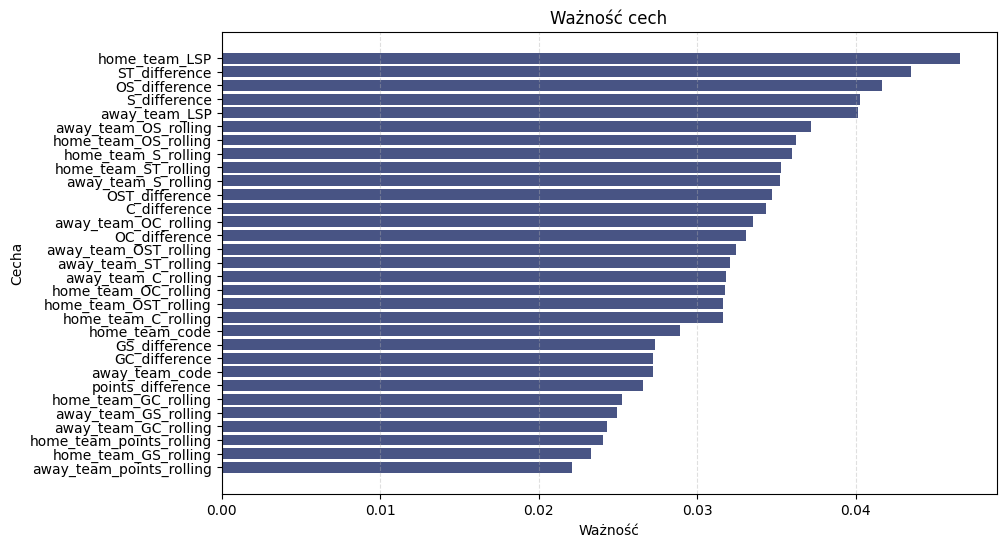

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color=colors[0])
plt.xlabel('Ważność')
plt.ylabel('Cecha')
plt.title('Ważność cech')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.xlim(0)
plt.show()

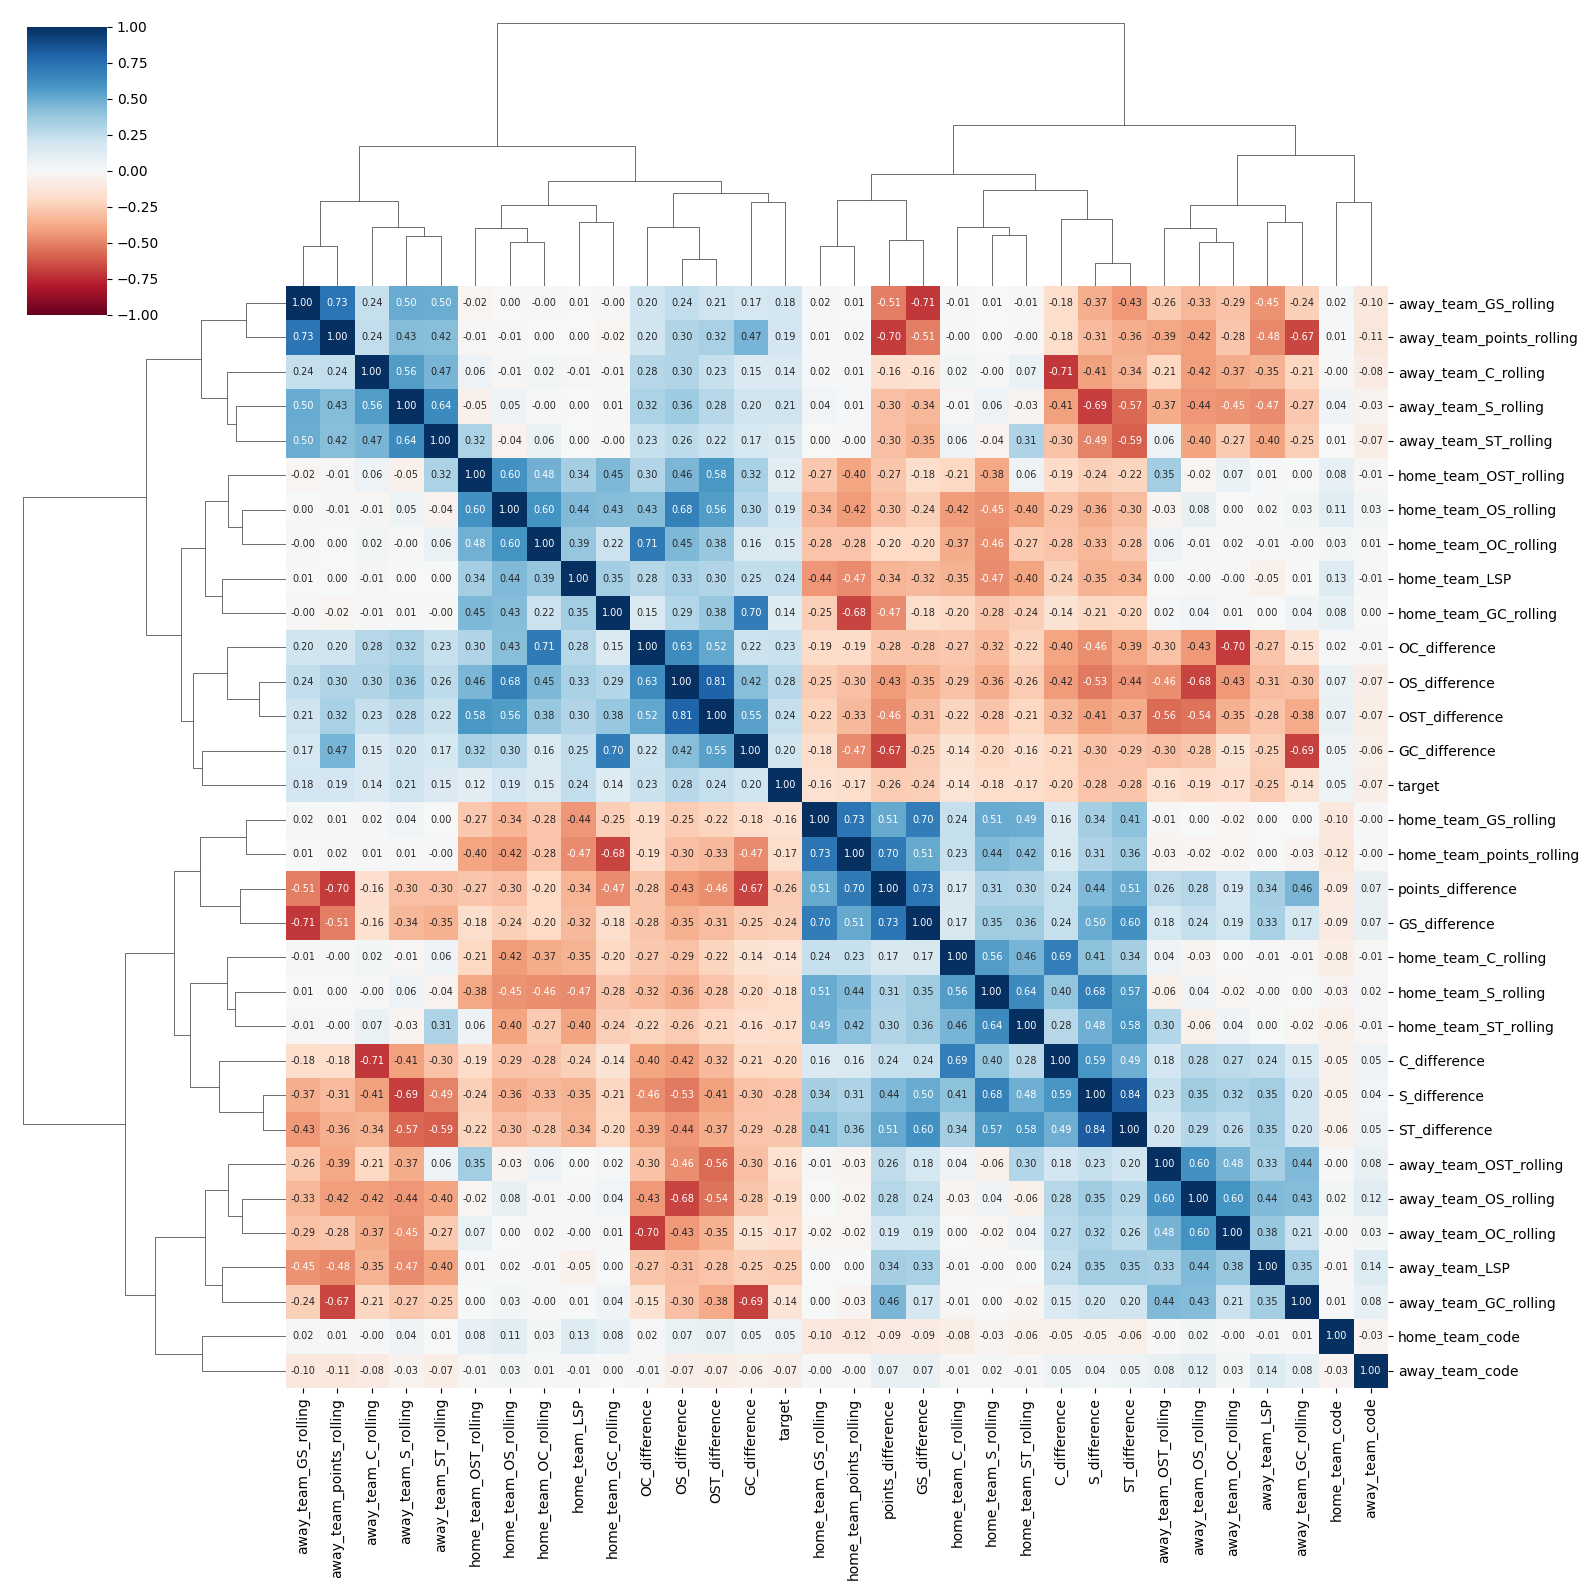

In [20]:
corr_matrix = df[predictors + ['target']].corr()

sns.clustermap(corr_matrix, method='complete', annot=True, cmap='RdBu', 
               fmt=".2f", annot_kws={"fontsize": 7}, vmin=-1, vmax=1, figsize=(16, 16))

In [21]:
predictors = [
    'home_team_LSP',
    'away_team_LSP',
    'home_team_code',
    'away_team_code',
    'GS_difference',
    'GC_difference',
    'ST_difference',
    'OS_difference'
]

X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.57; n=60


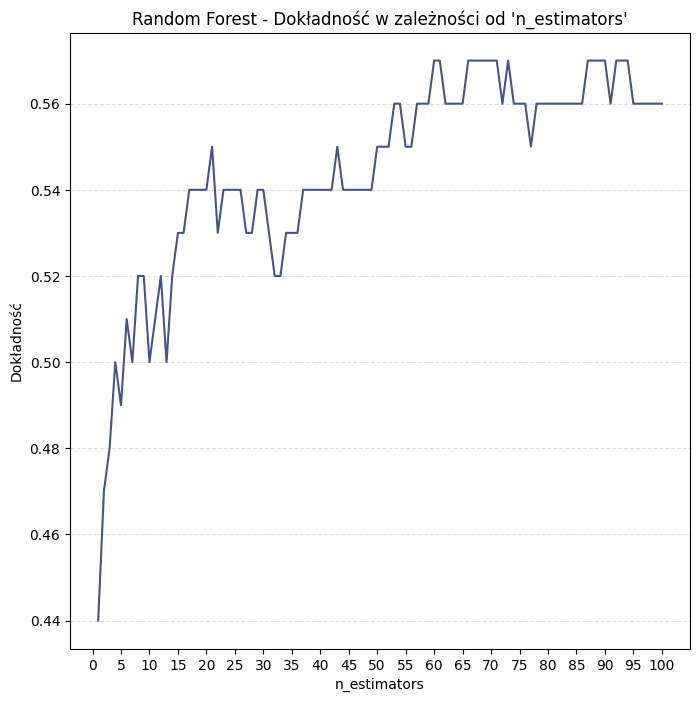

In [22]:
plot_scores_rf = []

for n_estimators in range(1, 101):
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=10, random_state=1)
    clf_rf.fit(X_train,y_train)
    test_preds = clf_rf.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_rf.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101), plot_scores_rf, color=colors[0])
plt.title("Random Forest - Dokładność w zależności od 'n_estimators'")
plt.xlabel('n_estimators')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_rf)
best_n_rf = plot_scores_rf.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_rf}')

In [23]:
rf = RandomForestClassifier(n_estimators=best_n_rf, min_samples_split=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=60, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.62      0.76      0.68       187
                Remis       0.41      0.08      0.14        84
     Zwycięstwo gości       0.50      0.61      0.55       109

             accuracy                           0.57       380
            macro avg       0.51      0.48      0.46       380
         weighted avg       0.54      0.57      0.52       380



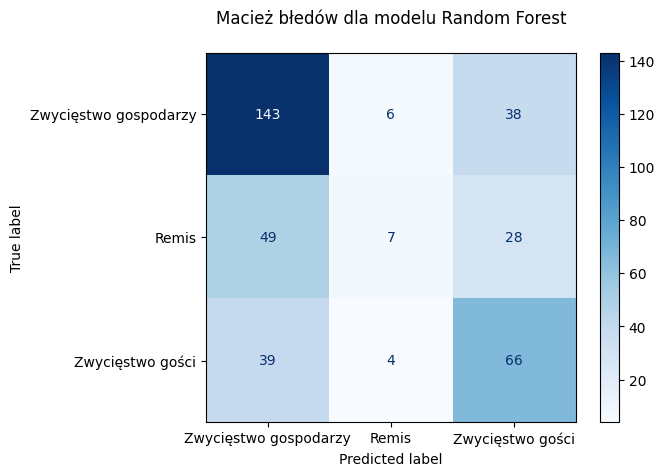

In [24]:
rf_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macież błedów dla modelu Random Forest\n')
plt.show()

In [25]:
rf_train_preds = rf.predict(X_train)

rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
print(f'Random Forest Train Accuracy: {rf_train_accuracy:.2f}')

Random Forest Train Accuracy: 0.89


***
Próba zbalansowania zbioru treningowego (oversampling)

In [26]:
class_counts = train['FTR'].value_counts()

print(class_counts)

FTR
H    1014
A     658
D     583
Name: count, dtype: Int64


In [27]:
class_counts = train['FTR'].value_counts()
majority_class = class_counts.idxmax()

balanced_train_over = pd.concat([
    resample(train[train['FTR'] == cls], 
             replace=True,
             n_samples=class_counts[majority_class],
             random_state=42)
    for cls in class_counts.index
])

print(balanced_train_over['FTR'].value_counts())

FTR
H    1014
A    1014
D    1014
Name: count, dtype: Int64


In [28]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [29]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=60, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.63      0.58      0.60       187
                Remis       0.37      0.27      0.32        84
     Zwycięstwo gości       0.44      0.59      0.51       109

             accuracy                           0.52       380
            macro avg       0.48      0.48      0.47       380
         weighted avg       0.52      0.52      0.51       380



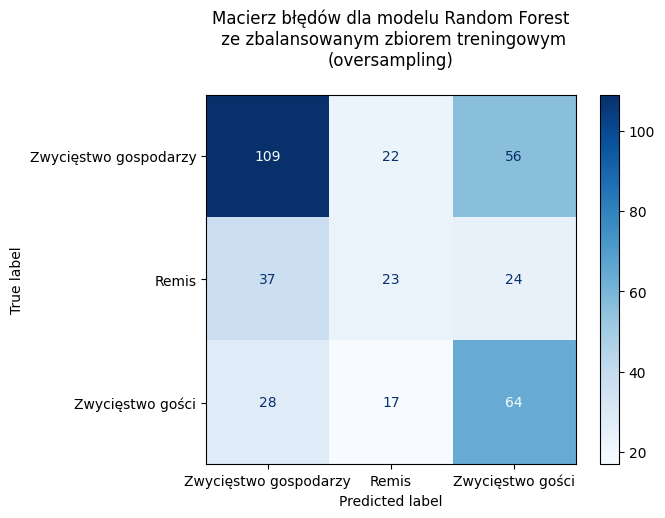

In [30]:
rf2_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf2_test_preds,
                              target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Random Forest\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

***
Próba zbalansowanie zbioru treningowego (undersampling)

In [31]:
class_counts = train['FTR'].value_counts()
minority_class = class_counts.idxmin()

balanced_train_under = pd.concat([
    resample(train[train['FTR'] == cls], 
             replace=False,
             n_samples=class_counts[minority_class],
             random_state=42)
    for cls in class_counts.index
])

print(balanced_train_under['FTR'].value_counts())


FTR
H    583
A    583
D    583
Name: count, dtype: Int64


In [32]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [33]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=60, random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.66      0.51      0.58       187
                Remis       0.29      0.31      0.30        84
     Zwycięstwo gości       0.46      0.61      0.52       109

             accuracy                           0.49       380
            macro avg       0.47      0.48      0.47       380
         weighted avg       0.52      0.49      0.50       380



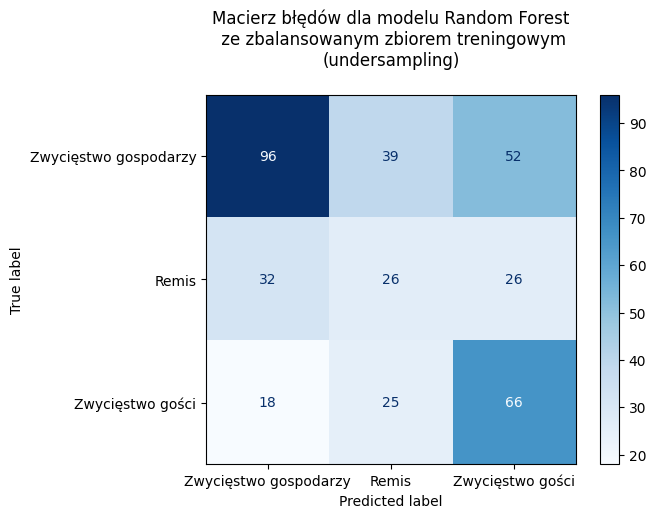

In [34]:
rf3_test_preds = rf.predict(X_test)

report = classification_report(y_test, rf3_test_preds,
                              target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, rf3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Random Forest\n ze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [35]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.58; n=66


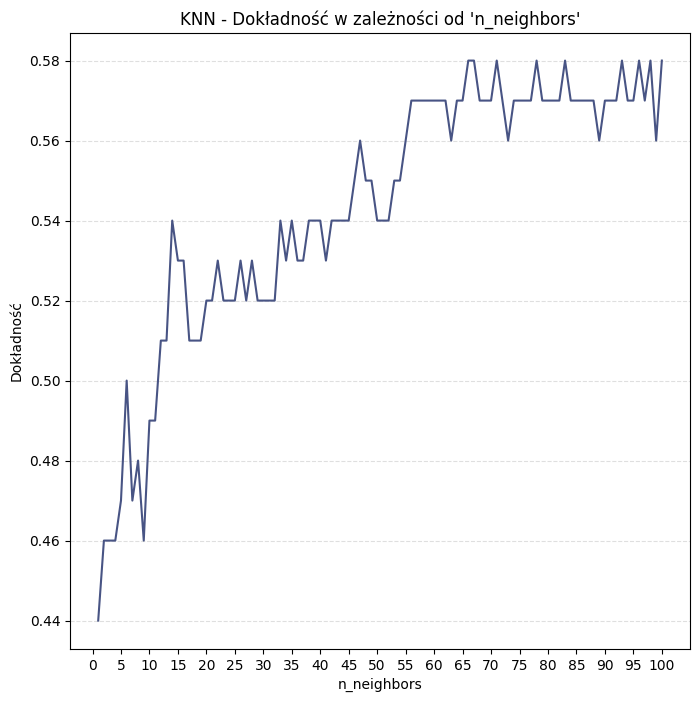

In [36]:
plot_scores_knn = []

for n_neighbors in range(1, 101):
    clf_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf_knn.fit(X_train,y_train)
    test_preds = clf_knn.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_knn.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101),plot_scores_knn, color=colors[0])
plt.title("KNN - Dokładność w zależności od 'n_neighbors'")
plt.xlabel('n_neighbors')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_knn)
best_n_knn = plot_scores_knn.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_knn}')

In [37]:
knn = KNeighborsClassifier(n_neighbors=best_n_knn)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=66)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.62      0.83      0.71       187
                Remis       0.18      0.04      0.06        84
     Zwycięstwo gości       0.54      0.56      0.55       109

             accuracy                           0.58       380
            macro avg       0.45      0.48      0.44       380
         weighted avg       0.50      0.58      0.52       380



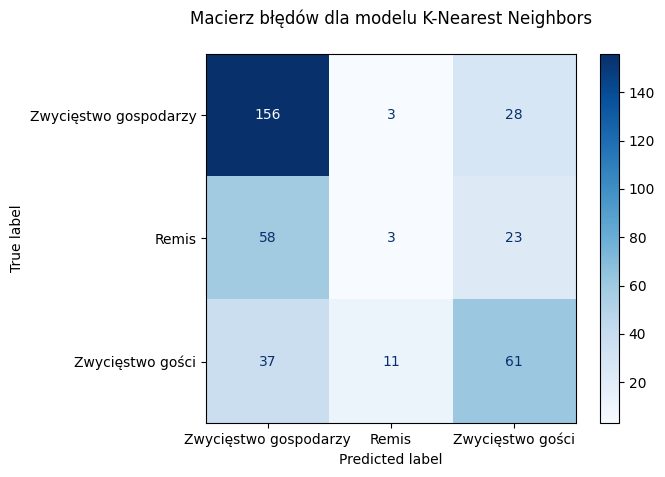

In [38]:
knn_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości']
)

print(report)

conf_matrix = confusion_matrix(y_test, knn_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\n')
plt.show()

In [39]:
knn_train_preds = knn.predict(X_train)

knn_train_accuracy = accuracy_score(y_train, knn_train_preds)
print(f'KNN Train accuracy: {knn_train_accuracy:.2f}')

KNN Train accuracy: 0.53


***
Próba wykorzystania zbalansowanego zbioru treningowego

In [40]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [41]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=66)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.65      0.51      0.57       187
                Remis       0.23      0.26      0.24        84
     Zwycięstwo gości       0.44      0.55      0.49       109

             accuracy                           0.47       380
            macro avg       0.44      0.44      0.44       380
         weighted avg       0.50      0.47      0.48       380



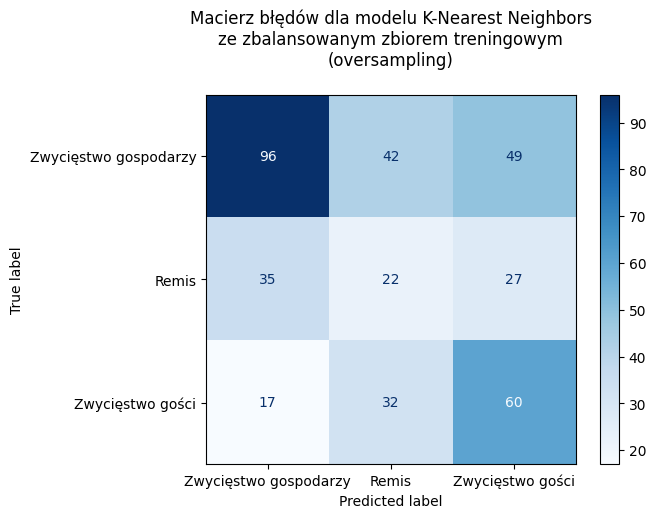

In [42]:
knn2_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, knn2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\nze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [43]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [44]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=66)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.66      0.51      0.57       187
                Remis       0.20      0.25      0.22        84
     Zwycięstwo gości       0.50      0.59      0.54       109

             accuracy                           0.47       380
            macro avg       0.45      0.45      0.44       380
         weighted avg       0.51      0.47      0.48       380



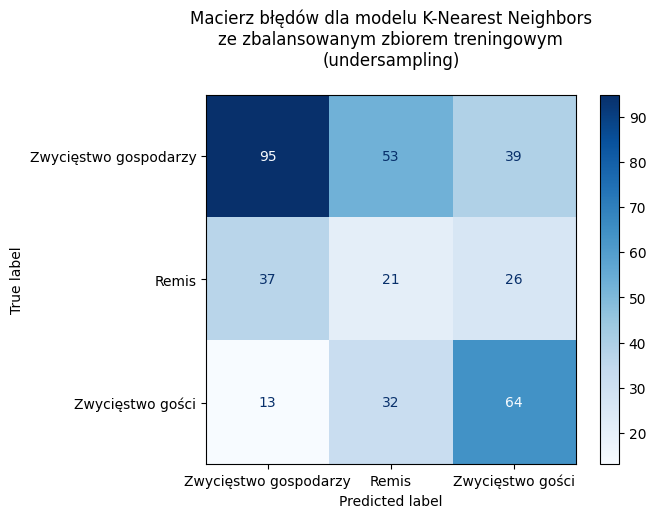

In [45]:
knn3_test_preds = knn.predict(X_test)

report = classification_report(y_test, knn3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, knn3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu K-Nearest Neighbors\nze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [46]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.57; c=0.01


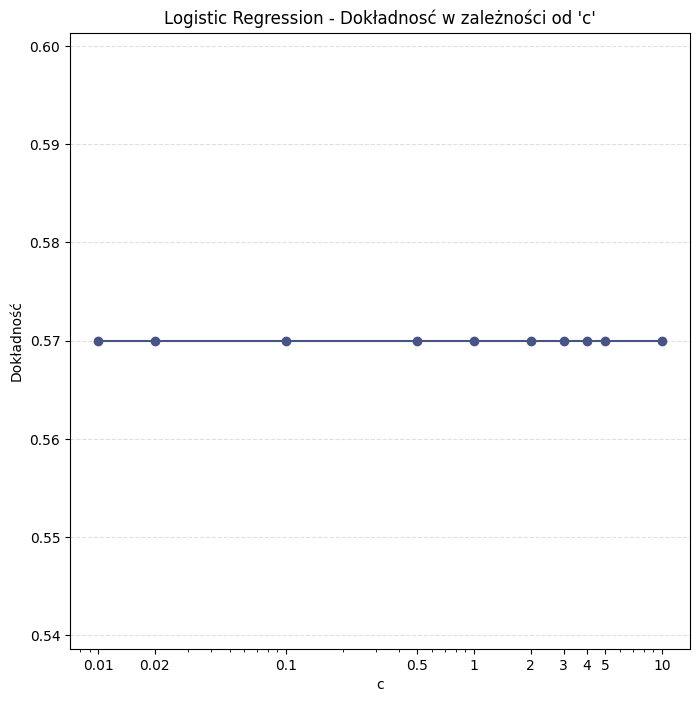

In [47]:
plot_scores_lr = []

cs = [0.01, 0.02, 0.1, 0.5, 1, 2, 3, 4, 5, 10]

for c in cs:
    lr = LogisticRegression(C=c, solver='lbfgs', multi_class='multinomial', max_iter=1000, random_state=1)
    lr.fit(X_train, y_train)
    test_preds = lr.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_lr.append(score)
 
plt.figure(figsize=(8, 8))
plt.plot(cs, plot_scores_lr, marker='o', color=colors[0])
plt.title("Logistic Regression - Dokładnosć w zależności od 'c'")
plt.xlabel("c")
plt.ylabel('Dokładność')
plt.xscale('log')
plt.xticks(cs, cs)
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_lr)
best_c_lr = cs[plot_scores_lr.index(best_accuracy)]
print(f'Best accuracy: {best_accuracy}; c={best_c_lr}')

In [48]:
lr = LogisticRegression(C=best_c_lr, solver='lbfgs', multi_class='multinomial', 
                        max_iter=1000, random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.81      0.68       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.53      0.61      0.57       109

             accuracy                           0.57       380
            macro avg       0.37      0.47      0.42       380
         weighted avg       0.44      0.57      0.50       380



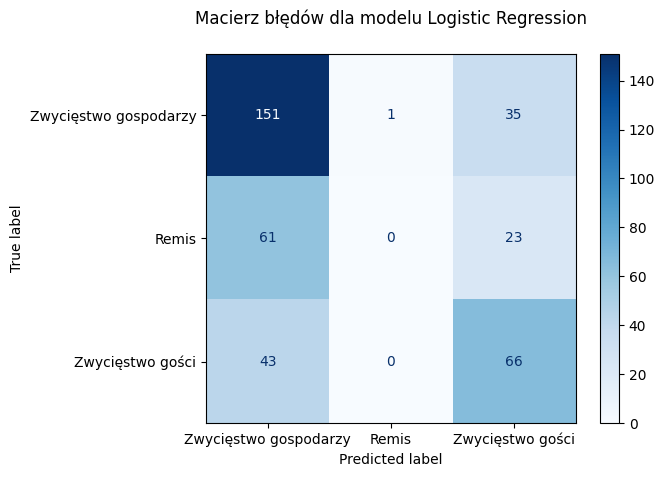

In [49]:
lr_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\n')
plt.show()

In [50]:
lr_train_preds = lr.predict(X_train)

lr_train_accuracy = accuracy_score(y_train, lr_train_preds)
print(f'Logistic Regression Train accuracy: {lr_train_accuracy:.2f}')

Logistic Regression Train accuracy: 0.52


***
Próba wykorzystania zbalansowanego zbioru treningowego

In [51]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [52]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.64      0.57      0.60       187
                Remis       0.24      0.20      0.22        84
     Zwycięstwo gości       0.50      0.65      0.57       109

             accuracy                           0.51       380
            macro avg       0.46      0.47      0.46       380
         weighted avg       0.51      0.51      0.51       380



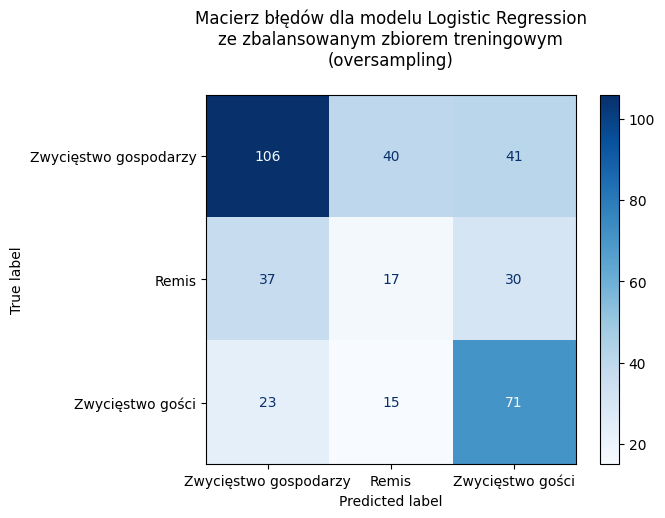

In [53]:
lr2_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\nze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [54]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [55]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, multi_class='multinomial',
                   random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.64      0.57      0.61       187
                Remis       0.24      0.19      0.21        84
     Zwycięstwo gości       0.51      0.69      0.58       109

             accuracy                           0.52       380
            macro avg       0.46      0.48      0.47       380
         weighted avg       0.52      0.52      0.51       380



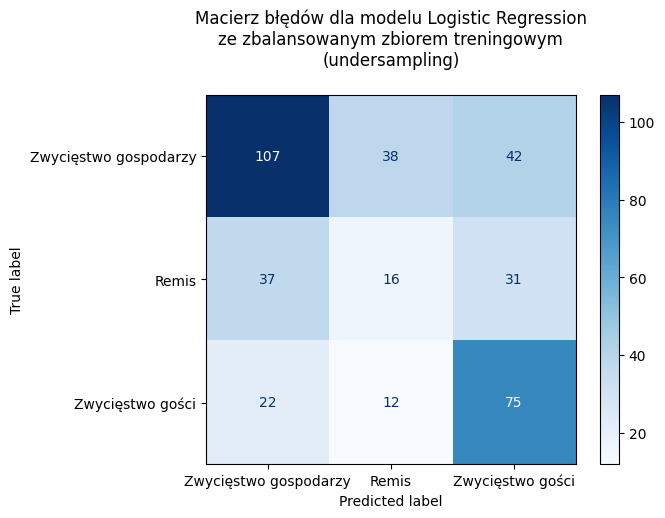

In [56]:
lr3_test_preds = lr.predict(X_test)

report = classification_report(y_test, lr3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, lr3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Logistic Regression\nze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [57]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.52; n=3


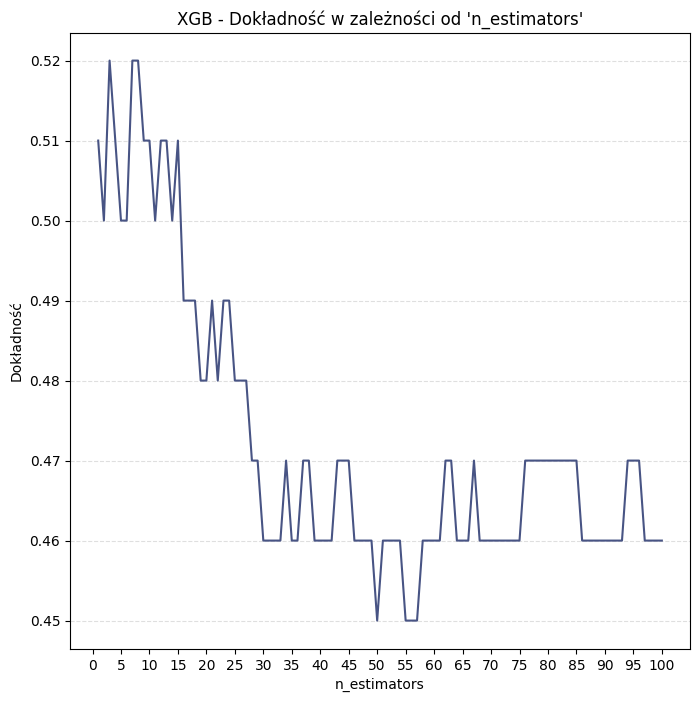

In [58]:
plot_scores_xgb = []

for n in range(1, 101):
    xgb = XGBClassifier(n_estimators=n, min_samples_split=10, random_state=1)
    xgb.fit(X_train,y_train)
    test_preds = xgb.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_xgb.append(score)
 
plt.figure(figsize = (8, 8))
plt.plot(range(1, 101), plot_scores_xgb, color=colors[0])
plt.title("XGB - Dokładność w zależności od 'n_estimators'")
plt.xlabel('n_estimators')
plt.ylabel('Dokładność')
plt.xticks(range(0, 101, 5))
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_xgb)
best_n_xgb = plot_scores_xgb.index(best_accuracy)+1
print(f'Best accuracy: {best_accuracy}; n={best_n_xgb}')

In [59]:
xgb = XGBClassifier(n_estimators=best_n_xgb, min_samples_split=10, random_state=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.58      0.68      0.63       187
                Remis       0.25      0.07      0.11        84
     Zwycięstwo gości       0.47      0.59      0.52       109

             accuracy                           0.52       380
            macro avg       0.43      0.45      0.42       380
         weighted avg       0.48      0.52      0.48       380



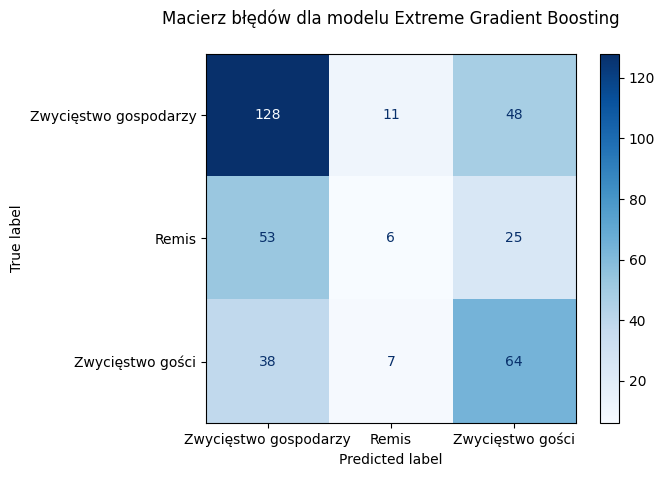

In [60]:
xgb_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n')
plt.show()

In [61]:
xgb_train_preds = xgb.predict(X_train)

xgb_train_accuracy = accuracy_score(y_train, xgb_train_preds)
print(f'XGB Train accuracy: {xgb_train_accuracy:.2f}')

XGB Train accuracy: 0.63


***
Próba zastosowania zbalansowanego zbioru treningowego

In [62]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [63]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.40      0.48       187
                Remis       0.29      0.39      0.33        84
     Zwycięstwo gości       0.42      0.53      0.47       109

             accuracy                           0.44       380
            macro avg       0.43      0.44      0.43       380
         weighted avg       0.47      0.44      0.44       380



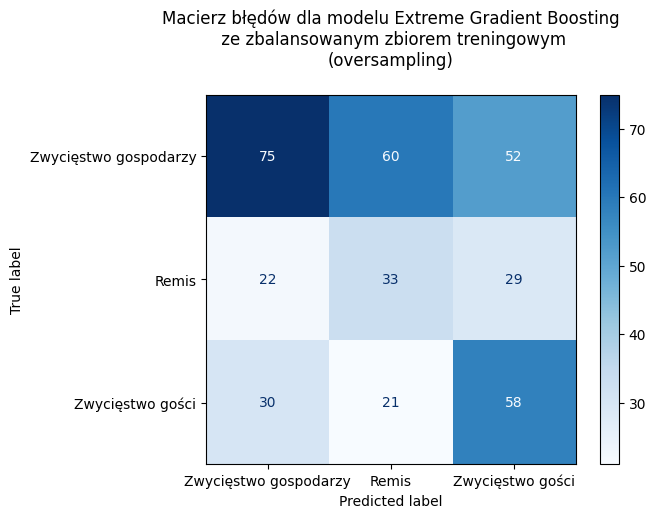

In [64]:
xgb2_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [65]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [66]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3,
              n_jobs=None, num_parallel_tree=None, ...)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.57      0.41      0.48       187
                Remis       0.23      0.27      0.25        84
     Zwycięstwo gości       0.46      0.61      0.53       109

             accuracy                           0.44       380
            macro avg       0.42      0.43      0.42       380
         weighted avg       0.47      0.44      0.44       380



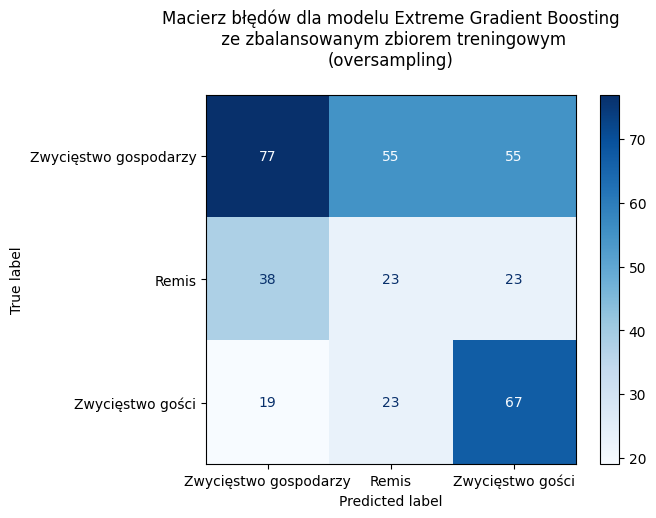

In [67]:
xgb3_test_preds = xgb.predict(X_test)

report = classification_report(y_test, xgb3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, xgb3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Extreme Gradient Boosting\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [68]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

Best accuracy: 0.58; c=1.0


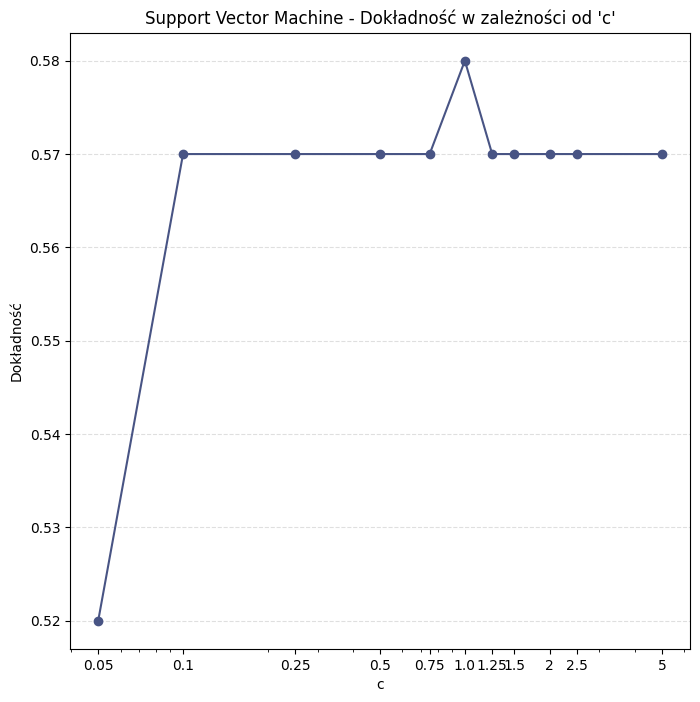

In [69]:
plot_scores_svc = []

cs = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2, 2.5, 5]

for c in cs:
    svc = SVC(kernel='rbf', C=c, random_state=1)
    svc.fit(X_train, y_train)
    test_preds = svc.predict(X_test)
    score = round(accuracy_score(y_test, test_preds), 2)
    plot_scores_svc.append(score)
 
plt.figure(figsize=(8, 8))
plt.plot(cs, plot_scores_svc, marker='o', color=colors[0])
plt.title("Support Vector Machine - Dokładność w zależności od 'c'")
plt.xlabel("c")
plt.ylabel("Dokładność")
plt.xscale('log') 
plt.xticks(cs, cs)
plt.grid(axis='y', linestyle='--', alpha=0.4)

best_accuracy = max(plot_scores_svc)
best_c_svc = cs[plot_scores_svc.index(best_accuracy)]
print(f'Best accuracy: {best_accuracy}; c={best_c_svc}')

In [70]:
svc = SVC(kernel='rbf', C=best_c_svc, random_state=1)
svc.fit(X_train, y_train)

SVC(random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.58      0.85      0.69       187
                Remis       0.00      0.00      0.00        84
     Zwycięstwo gości       0.57      0.55      0.56       109

             accuracy                           0.58       380
            macro avg       0.38      0.47      0.42       380
         weighted avg       0.45      0.58      0.50       380



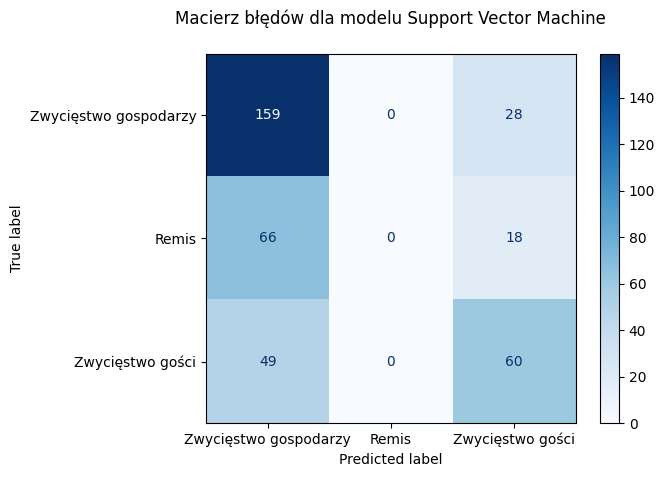

In [71]:
svc_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Machine\n')
plt.show()

In [72]:
svc_train_preds = svc.predict(X_train)

svc_train_accuracy = accuracy_score(y_train, svc_train_preds)
print(f'SVM Train accuracy: {svc_train_accuracy:.2f}')

SVM Train accuracy: 0.52


***
Proba zastosowania zbalansowangeo zbioru treningowego

In [73]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [74]:
svc.fit(X_train, y_train)

SVC(random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.66      0.53      0.59       187
                Remis       0.28      0.32      0.30        84
     Zwycięstwo gości       0.49      0.61      0.54       109

             accuracy                           0.51       380
            macro avg       0.48      0.49      0.48       380
         weighted avg       0.53      0.51      0.51       380



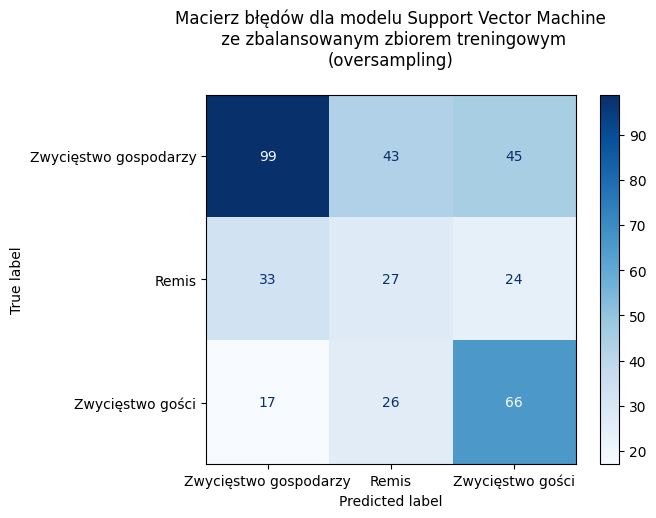

In [75]:
svc2_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc2_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc2_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Machine\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [76]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [77]:
svc.fit(X_train, y_train)

SVC(random_state=1)

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.65      0.56      0.60       187
                Remis       0.21      0.21      0.21        84
     Zwycięstwo gości       0.50      0.62      0.56       109

             accuracy                           0.50       380
            macro avg       0.46      0.47      0.46       380
         weighted avg       0.51      0.50      0.50       380



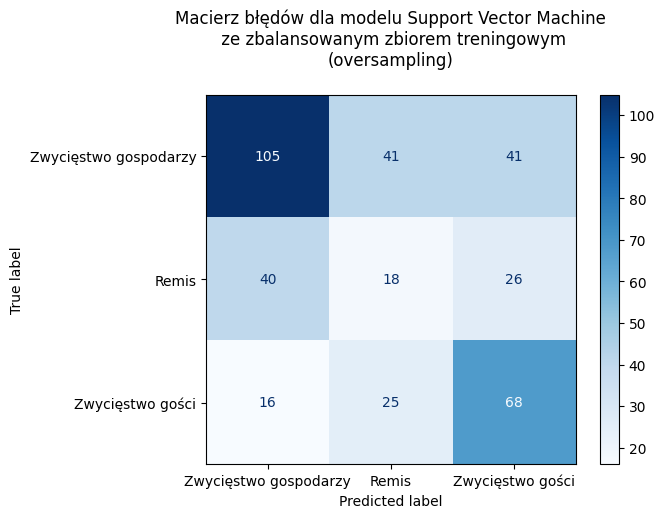

In [78]:
svc3_test_preds = svc.predict(X_test)

report = classification_report(y_test, svc3_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, svc3_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Support Vector Machine\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [79]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [80]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [81]:
nn = Sequential()
nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(3, activation='softmax'))

In [82]:
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [83]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


57/57 [==============================] - 1s 4ms/step - loss: 1.0456 - accuracy: 0.4623 - val_loss: 1.0560 - val_accuracy: 0.4457
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9805 - accuracy: 0.5316 - val_loss: 1.0551 - val_accuracy: 0.4479
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9710 - accuracy: 0.5299 - val_loss: 1.0501 - val_accuracy: 0.4545
Epoch 4/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9638 - accuracy: 0.5333 - val_loss: 1.0478 - val_accuracy: 0.4523
Epoch 5/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9577 - accuracy: 0.5421 - val_loss: 1.0494 - val_accuracy: 0.4479
Epoch 6/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9542 - accuracy: 0.5466 - val_loss: 1.0507 - val_accuracy: 0.4501
Epoch 7/50
57/57 [==============================] - 0s 2ms/step - loss: 0.9495 - accuracy: 0.5449 - val_loss: 1.0535 - val_accuracy: 0.4501
Epoch 8/50
57/57 [

In [84]:
nn_test_preds = nn.predict(X_test)
nn_test_preds = np.argmax(nn_test_preds, axis=1)

12/12 [==============================] - 0s 1ms/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.60      0.78      0.67       187
                Remis       0.33      0.12      0.18        84
     Zwycięstwo gości       0.53      0.52      0.53       109

             accuracy                           0.56       380
            macro avg       0.49      0.47      0.46       380
         weighted avg       0.52      0.56      0.52       380



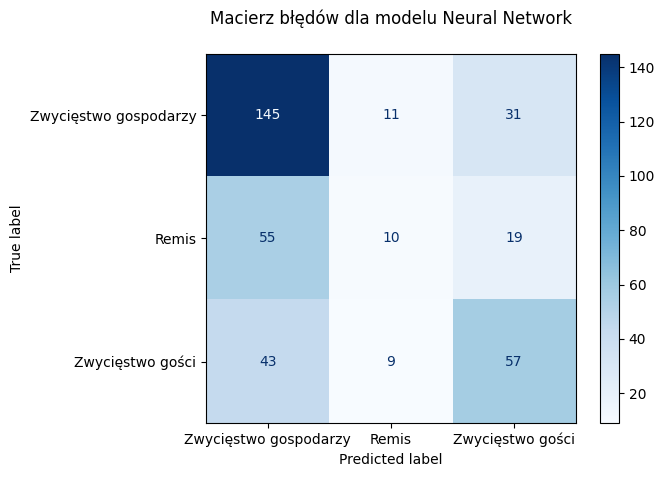

In [85]:
nn_report = classification_report(y_test, nn_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(nn_report)

nn_conf_matrix = confusion_matrix(y_test, nn_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n')
plt.show()

In [86]:
nn_train_preds = nn.predict(X_train)
nn_train_preds = np.argmax(nn_train_preds, axis=1)

nn_train_accuracy = accuracy_score(y_train, nn_train_preds)
print(f'Neural Network Train accuracy: {nn_train_accuracy:.2f}')

71/71 [==============================] - 0s 878us/step
Neural Network Train accuracy: 0.60


***
Próba zastosowania zbalansowanego zbioru treningowego

In [87]:
X_train = balanced_train_over[predictors]
y_train = balanced_train_over['target']

X_test = test[predictors]
y_test = test['target']

In [88]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [89]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
77/77 [==============================] - 0s 2ms/step - loss: 0.8140 - accuracy: 0.6556 - val_loss: 1.2615 - val_accuracy: 0.2956
Epoch 2/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7871 - accuracy: 0.6597 - val_loss: 1.7391 - val_accuracy: 0.0788
Epoch 3/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7741 - accuracy: 0.6642 - val_loss: 1.6401 - val_accuracy: 0.1346
Epoch 4/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7647 - accuracy: 0.6757 - val_loss: 1.6538 - val_accuracy: 0.1215
Epoch 5/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7534 - accuracy: 0.6782 - val_loss: 1.5320 - val_accuracy: 0.1773
Epoch 6/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7455 - accuracy: 0.6885 - val_loss: 1.5231 - val_accuracy: 0.1806
Epoch 7/50
77/77 [==============================] - 0s 2ms/step - loss: 0.7327 - accuracy: 0.7037 - val_loss: 1.5827 - val_accuracy: 0.1888
Epoch 8/50
77/77 [==

In [90]:
nn2_test_preds = nn.predict(X_test)
nn2_test_preds = np.argmax(nn2_test_preds, axis=1)

12/12 [==============================] - 0s 1ms/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.55      0.53      0.54       187
                Remis       0.24      0.11      0.15        84
     Zwycięstwo gości       0.36      0.53      0.43       109

             accuracy                           0.44       380
            macro avg       0.38      0.39      0.37       380
         weighted avg       0.43      0.44      0.42       380



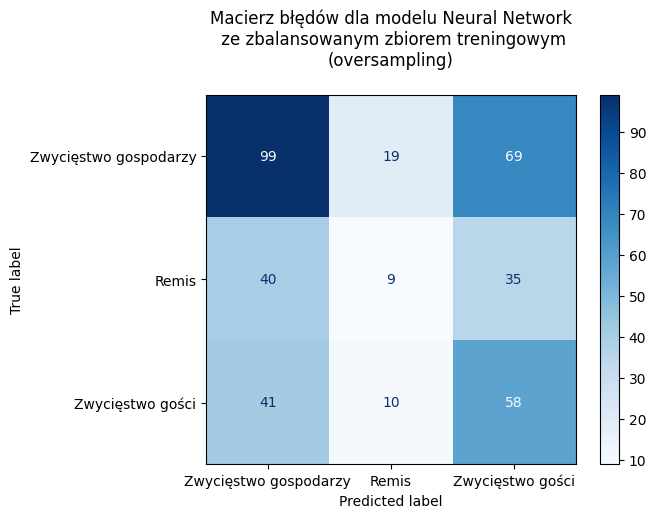

In [91]:
report = classification_report(y_test, nn2_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

nn_conf_matrix = confusion_matrix(y_test, nn2_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n ze zbalansowanym zbiorem treningowym\n(oversampling)\n')
plt.show()

In [92]:
X_train = balanced_train_under[predictors]
y_train = balanced_train_under['target']

X_test = test[predictors]
y_test = test['target']

In [93]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [94]:
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
44/44 [==============================] - 0s 3ms/step - loss: 0.8797 - accuracy: 0.6576 - val_loss: 1.3322 - val_accuracy: 0.4314
Epoch 2/50
44/44 [==============================] - 0s 2ms/step - loss: 0.8352 - accuracy: 0.6662 - val_loss: 1.2497 - val_accuracy: 0.4400
Epoch 3/50
44/44 [==============================] - 0s 2ms/step - loss: 0.8048 - accuracy: 0.6798 - val_loss: 1.3966 - val_accuracy: 0.3600
Epoch 4/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7746 - accuracy: 0.6841 - val_loss: 1.4300 - val_accuracy: 0.3371
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7693 - accuracy: 0.6912 - val_loss: 1.6149 - val_accuracy: 0.2914
Epoch 6/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7548 - accuracy: 0.6976 - val_loss: 1.6211 - val_accuracy: 0.2686
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 0.7411 - accuracy: 0.7034 - val_loss: 1.3131 - val_accuracy: 0.3657
Epoch 8/50
44/44 [==

In [95]:
nn3_test_preds = nn.predict(X_test)
nn3_test_preds = np.argmax(nn3_test_preds, axis=1)

12/12 [==============================] - 0s 969us/step


                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.56      0.53      0.54       187
                Remis       0.12      0.02      0.04        84
     Zwycięstwo gości       0.39      0.66      0.49       109

             accuracy                           0.46       380
            macro avg       0.35      0.40      0.36       380
         weighted avg       0.41      0.46      0.42       380



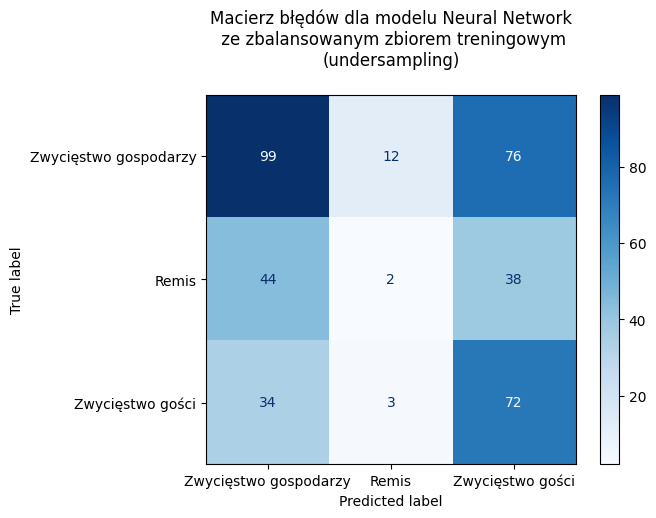

In [96]:
report = classification_report(y_test, nn3_test_preds, 
                                  target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

nn_conf_matrix = confusion_matrix(y_test, nn3_test_preds, labels=[0, 1, 2])
nn_disp = ConfusionMatrixDisplay(confusion_matrix=nn_conf_matrix, 
                                 display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

nn_disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Neural Network\n ze zbalansowanym zbiorem treningowym\n(undersampling)\n')
plt.show()

In [97]:
X_train = train[predictors]
y_train = train['target']

X_test = test[predictors]
y_test = test['target']

In [98]:
estimators = [('xgb', xgb), ('knn', knn)]

stacked = StackingClassifier(
    estimators=estimators,
    final_estimator=rf
)
                                   
stacked.fit(X_train, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              min_samples_split=10, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=3, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('knn', KNeighborsClassifier(n_neighbors=66))],
                   final_estimator=RandomForestClassifier(min_samples_split=10,
                                                          n_estimators=60,
                                                          random_state=1))

                       precision    recall  f1-score   support

Zwycięstwo gospodarzy       0.59      0.65      0.62       187
                Remis       0.26      0.18      0.21        84
     Zwycięstwo gości       0.47      0.50      0.48       109

             accuracy                           0.50       380
            macro avg       0.44      0.44      0.44       380
         weighted avg       0.48      0.50      0.49       380



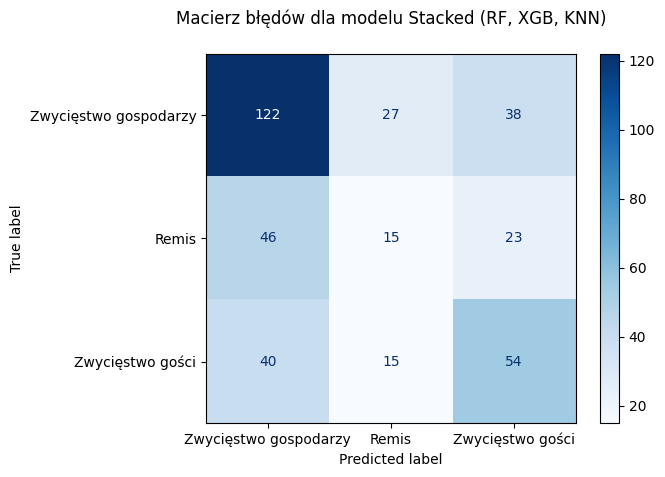

In [99]:
stacked_test_preds = stacked.predict(X_test)

report = classification_report(y_test, stacked_test_preds, 
                               target_names=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

print(report)

conf_matrix = confusion_matrix(y_test, stacked_test_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['Zwycięstwo gospodarzy', 'Remis', 'Zwycięstwo gości'])

disp.plot(values_format='d', cmap=plt.cm.Blues)
plt.title('Macierz błędów dla modelu Stacked (RF, XGB, KNN)\n')
plt.show()

In [100]:
sets = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for i in range(1,11):
    training_sets = []
    test_sets = []
    
    for j in range(0,10):
        if i == 1:
            training_sets.append(df[(df['season'] == 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 2:
            training_sets.append(df[(df['season'] >= 2011+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 3:
            training_sets.append(df[(df['season'] >= 2010+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 4:
            training_sets.append(df[(df['season'] >= 2009+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 5:
            training_sets.append(df[(df['season'] >= 2008+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 6:
            training_sets.append(df[(df['season'] >= 2007+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 7:
            training_sets.append(df[(df['season'] >= 2006+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 8:
            training_sets.append(df[(df['season'] >= 2005+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
            
        elif i == 9:
            training_sets.append(df[(df['season'] >= 2004+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])
        
        elif i == 10:
            training_sets.append(df[(df['season'] >= 2003+j) & (df['season'] <= 2012+j)])
            test_sets.append(df[df['season'] == 2013+j])

    sets[f'trained_on_{i}_seasons'].append(training_sets)
    sets[f'trained_on_{i}_seasons'].append(test_sets)

In [101]:
models = [rf, knn, lr, xgb, svc, nn, stacked]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Machine',
    'sequential': 'Neural Network',
    'stackingclassifier': 'Stacked (RF, XGB, KNN)'
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

correct_predictions_by_team = {model_names[model] : defaultdict(int) for model in model_names}
number_of_predictions_by_team = defaultdict(int)

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):

            X_train = train[predictors]
            y_train = train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            if i >= 6:
            
                for pred_label, actual_label, home_team_code, away_team_code in zip(
                    preds, y_test, X_test['home_team_code'], X_test['away_team_code']
                ):
                    if pred_label == actual_label:
                        correct_predictions_by_team[
                            model_names[model.__class__.__name__.lower()]
                        ][team_names[home_team_code]] += 1

                        correct_predictions_by_team[
                            model_names[model.__class__.__name__.lower()]
                        ][team_names[away_team_code]] += 1

                    # zeby nie zliczac ilosci predykcji kilka razy
                    if model == rf:
                        number_of_predictions_by_team[team_names[home_team_code]] += 1
                        number_of_predictions_by_team[team_names[away_team_code]] += 1
                    
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.544

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.5236842105263158

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.464

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.44473684210526315

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.5324324324324324

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.5657894736842105

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.49736842105263157

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.46578947368421053

Training season/s: [2020]
Test season: [2021]
Accuracy: 0.5066666666666667

Training season/s: [2021]
Test season: [2022]
Accuracy: 0.49333333333333335

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.5253333333333333

Traini

Accuracy: 0.5546666666666666

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.5253333333333333

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Extreme Gradient Boosting model on 2 season/s

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.488

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.4921052631578947

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.44533333333333336

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.5

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.43513513513513513

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.5368421052631579

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.5026315789473684

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.45

Training season/s: [2019, 2020]
Test season: [2021]
Accuracy: 0.5226666666666666

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.472

^v^v^v^v^v^v^v^v^v^v^v

Accuracy: 0.4842105263157895

Training season/s: [2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5413333333333333

Training season/s: [2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.5573333333333333

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 3 season/s

Training season/s: [2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.4826666666666667

Training season/s: [2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.46578947368421053

Training season/s: [2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.45066666666666666

Training season/s: [2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5263157894736842

Training season/s: [2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5027027027027027

Training season/s: [2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.531578947368421

Training season/s: [2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5078947368421053

Training season/s: [2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.5105263157894737

T

Accuracy: 0.48

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 4 season/s

Training season/s: [2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.49066666666666664

Training season/s: [2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.45789473684210524

Training season/s: [2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.42133333333333334

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.45789473684210524

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5

Training season/s: [2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5157894736842106

Training season/s: [2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5131578947368421

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.45789473684210524

Training season/s: [2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.48

Training season/s: [2018, 2019, 2020, 2021]
Test season: [2022]
Ac

Accuracy: 0.4921052631578947

Training season/s: [2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4631578947368421

Training season/s: [2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5066666666666667

Training season/s: [2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.496

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 6 season/s

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.568

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5263157894736842

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.45066666666666666

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5684210526315789

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.56052

Accuracy: 0.49066666666666664

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 7 season/s

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5493333333333333

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5157894736842106

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4666666666666667

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5631578947368421

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5297297297297298

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5763157894736842

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4921052631578947

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4763

Accuracy: 0.49866666666666665

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 8 season/s

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5493333333333333

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5105263157894737

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.45866666666666667

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5657894736842105

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5162162162162162

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5684210526315789

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.49473684210526314

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017

Accuracy: 0.4756756756756757

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5078947368421053

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.47368421052631576

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.45263157894736844

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.496

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.504

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 9 season/s

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.56

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5210526315789473

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test seas

Accuracy: 0.4710526315789474

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.44

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.44533333333333336

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 9 season/s

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.488

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.531578947368421

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.41333333333333333

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5342105263157895

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4810810810810811

Training season/s: [2009, 2010, 

Accuracy: 0.56

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.5546666666666666

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5733333333333334

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.531578947368421

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.472

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.531578947368421

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5108108108108108

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5184210526315789



In [102]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_accuracies_mean = pd.DataFrame(data).round(3)

df_accuracies_mean

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0          0.504                0.504                0.517   
1          0.512                0.509                0.527   
2          0.520                0.516                0.533   
3          0.518                0.522                0.535   
4          0.514                0.532                0.539   
5          0.524                0.532                0.539   
6          0.523                0.523                0.538   
7          0.520                0.527                0.539   
8          0.524                0.530                0.540   
9          0.520                0.527                0.540   

   Extreme Gradient Boosting  Support Vector Machine  Neural Network  \
0                      0.464                   0.512           0.432   
1                      0.484                   0.521           0.462   
2                      0.491                   0.534           0.491   
3                      0.499                   0.533           0.472   
4                      0.503                   0.536           0.483   
5                      0.515                   0.536           0.491   
6                      0.509                   0.537           0.495   
7                      0.517                   0.536           0.479   
8                      0.524                   0.536           0.499   
9                      0.514                   0.535           0.504   

   Stacked (RF, XGB, KNN)  
0                   0.463  
1                   0.469  
2                   0.483  
3                   0.479  
4                   0.495  
5                   0.499  
6                   0.502  
7                   0.486  
8                   0.497  
9                   0.500

In [103]:
df_accuracies_mean = df_accuracies_mean.T
df_accuracies_mean

0      1      2      3      4      5      6  \
Random Forest              0.504  0.512  0.520  0.518  0.514  0.524  0.523   
K-Nearest Neighbors        0.504  0.509  0.516  0.522  0.532  0.532  0.523   
Logistic Regression        0.517  0.527  0.533  0.535  0.539  0.539  0.538   
Extreme Gradient Boosting  0.464  0.484  0.491  0.499  0.503  0.515  0.509   
Support Vector Machine     0.512  0.521  0.534  0.533  0.536  0.536  0.537   
Neural Network             0.432  0.462  0.491  0.472  0.483  0.491  0.495   
Stacked (RF, XGB, KNN)     0.463  0.469  0.483  0.479  0.495  0.499  0.502   

                               7      8      9  
Random Forest              0.520  0.524  0.520  
K-Nearest Neighbors        0.527  0.530  0.527  
Logistic Regression        0.539  0.540  0.540  
Extreme Gradient Boosting  0.517  0.524  0.514  
Support Vector Machine     0.536  0.536  0.535  
Neural Network             0.479  0.499  0.504  
Stacked (RF, XGB, KNN)     0.486  0.497  0.500

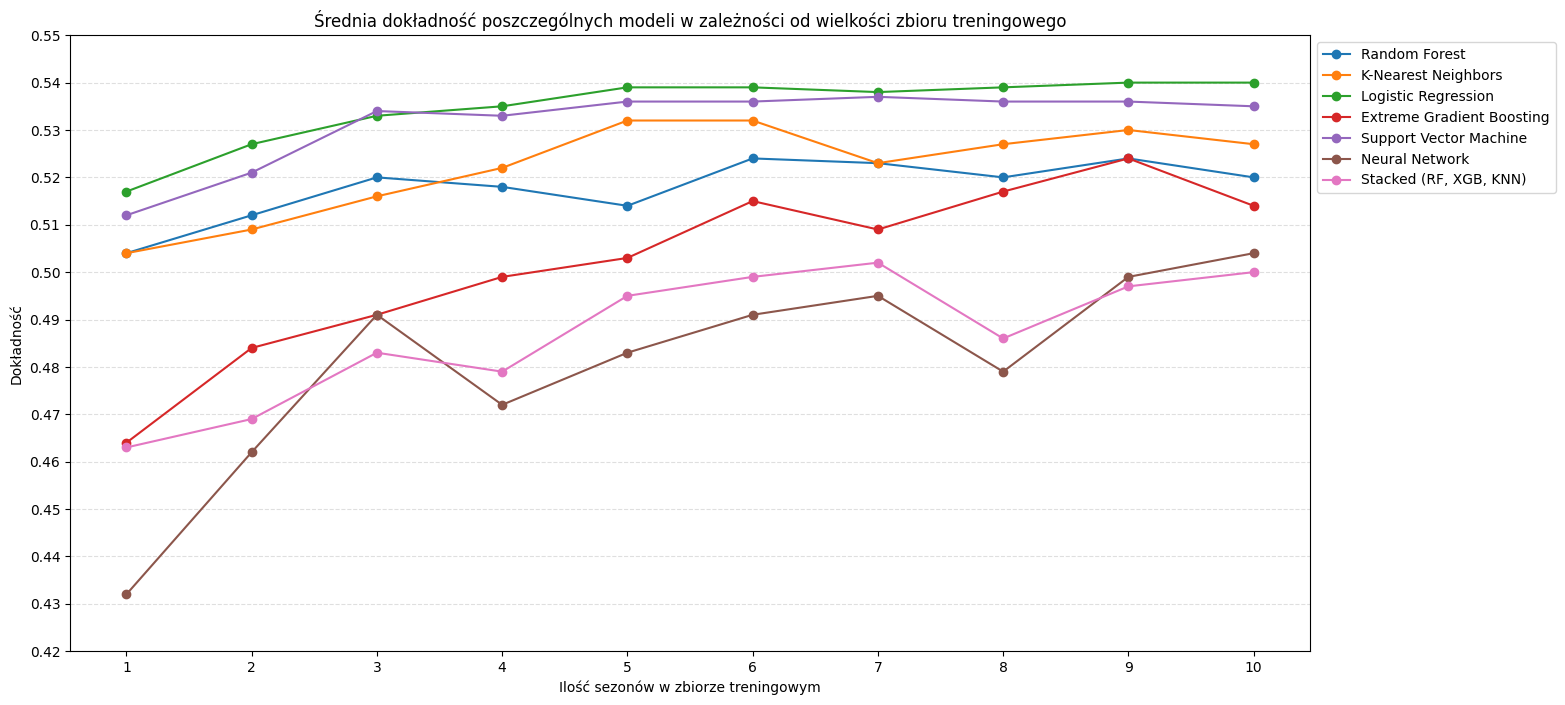

In [104]:
plt.figure(figsize=(16, 8))

for model, accuracies in df_accuracies_mean.iterrows():
    plt.plot(range(1,11), accuracies, marker='o', label=model)

plt.title('Średnia dokładność poszczególnych modeli w zależności od wielkości zbioru treningowego')
plt.xlabel('Ilość sezonów w zbiorze treningowym')
plt.ylabel('Dokładność')
plt.xticks(range(1,11))

min_y = round(df_accuracies_mean.min().min(), 2) - 0.01
max_y = round(df_accuracies_mean.max().max(), 2) + 0.01
    
plt.yticks(np.arange(min_y, max_y , 0.01))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

In [105]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_accuracies = pd.DataFrame(data).round(2)

df_accuracies

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0            0.54                 0.53                 0.52   
1            0.52                 0.52                 0.51   
2            0.46                 0.43                 0.45   
3            0.44                 0.49                 0.52   
4            0.53                 0.52                 0.55   
..            ...                  ...                  ...   
95           0.59                 0.59                 0.60   
96           0.52                 0.52                 0.51   
97           0.46                 0.50                 0.50   
98           0.53                 0.52                 0.57   
99           0.51                 0.53                 0.55   

    Extreme Gradient Boosting  Support Vector Machine  Neural Network  \
0                        0.45                    0.56            0.44   
1                        0.49                    0.51            0.43   
2                        0.42                    0.45            0.44   
3                        0.43                    0.49            0.36   
4                        0.50                    0.54            0.45   
..                        ...                     ...             ...   
95                       0.58                    0.59            0.52   
96                       0.50                    0.51            0.49   
97                       0.46                    0.48            0.46   
98                       0.54                    0.56            0.50   
99                       0.50                    0.55            0.46   

    Stacked (RF, XGB, KNN)  
0                     0.46  
1                     0.49  
2                     0.42  
3                     0.41  
4                     0.49  
..                     ...  
95                    0.57  
96                    0.51  
97                    0.47  
98                    0.49  
99                    0.50  

[100 rows x 7 columns]

In [106]:
df_accuracies.mean()

Random Forest                0.5182
K-Nearest Neighbors          0.5223
Logistic Regression          0.5351
Extreme Gradient Boosting    0.5019
Support Vector Machine       0.5319
Neural Network               0.4806
Stacked (RF, XGB, KNN)       0.4872
dtype: float64

In [107]:
df_accuracies.max()

Random Forest                0.59
K-Nearest Neighbors          0.61
Logistic Regression          0.61
Extreme Gradient Boosting    0.60
Support Vector Machine       0.60
Neural Network               0.58
Stacked (RF, XGB, KNN)       0.57
dtype: float64

In [108]:
df_accuracies.min()

Random Forest                0.43
K-Nearest Neighbors          0.43
Logistic Regression          0.44
Extreme Gradient Boosting    0.42
Support Vector Machine       0.44
Neural Network               0.36
Stacked (RF, XGB, KNN)       0.41
dtype: float64

In [109]:
df_accuracies.iloc[49:].mean()

Random Forest                0.521961
K-Nearest Neighbors          0.528039
Logistic Regression          0.540000
Extreme Gradient Boosting    0.515686
Support Vector Machine       0.536078
Neural Network               0.492745
Stacked (RF, XGB, KNN)       0.496471
dtype: float64

In [110]:
df_accuracies.iloc[49:].max()

Random Forest                0.59
K-Nearest Neighbors          0.61
Logistic Regression          0.61
Extreme Gradient Boosting    0.60
Support Vector Machine       0.60
Neural Network               0.58
Stacked (RF, XGB, KNN)       0.57
dtype: float64

In [111]:
df_accuracies.iloc[49:].min()

Random Forest                0.45
K-Nearest Neighbors          0.43
Logistic Regression          0.44
Extreme Gradient Boosting    0.43
Support Vector Machine       0.44
Neural Network               0.38
Stacked (RF, XGB, KNN)       0.41
dtype: float64

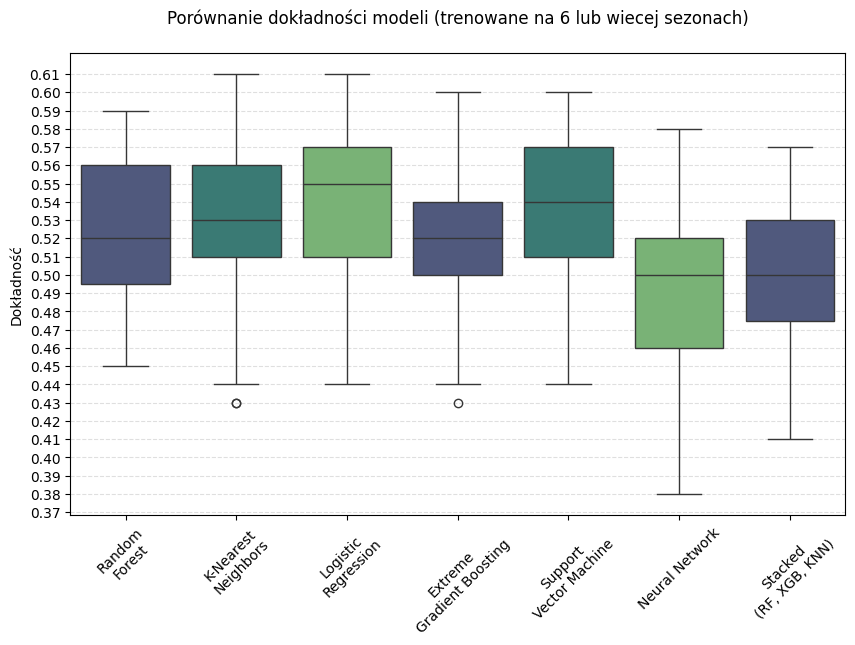

In [112]:
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(data=df_accuracies.iloc[49:], palette=colors)
plt.title('Porównanie dokładności modeli (trenowane na 6 lub wiecej sezonach)\n')
plt.ylabel('Dokładność')
plt.xticks(rotation=45)

min_y = round(df_accuracies.iloc[49:].min().min(), 2) - 0.01
max_y = round(df_accuracies.iloc[49:].max().max(), 2) + 0.01
plt.yticks(np.arange(min_y, max_y , 0.01))

custom_labels = [
    'Random\nForest', 'K-Nearest\nNeighbors', 'Logistic\nRegression', 'Extreme\nGradient Boosting', 
    'Support\nVector Machine', 'Neural Network', 'Stacked\n(RF, XGB, KNN)']
plt.gca().set_xticklabels(custom_labels)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [113]:
data_dict = {}

for model, data_dict_model in correct_predictions_by_team.items():
    for team, correct_predictions in data_dict_model.items():
        if team not in data_dict:
            data_dict[team] = {}
        total_predictions = number_of_predictions_by_team[team]
        percentage_correct = (correct_predictions / total_predictions)
        data_dict[team][model] = percentage_correct

correct_predictions_df = pd.DataFrame(data_dict).transpose()
correct_predictions_df.reset_index(inplace=True)
correct_predictions_df.rename(columns={'index': 'team'}, inplace=True)
correct_predictions_df = correct_predictions_df.round(2)

correct_predictions_df.head()

team  Random Forest  K-Nearest Neighbors  Logistic Regression  \
0   Liverpool           0.60                 0.61                 0.62   
1       Stoke           0.48                 0.45                 0.49   
2     Swansea           0.53                 0.50                 0.52   
3  Man United           0.53                 0.55                 0.55   
4     Chelsea           0.56                 0.55                 0.56   

   Extreme Gradient Boosting  Support Vector Machine  Neural Network  \
0                       0.59                    0.61            0.56   
1                       0.48                    0.49            0.45   
2                       0.52                    0.53            0.49   
3                       0.53                    0.55            0.50   
4                       0.55                    0.56            0.53   

   Stacked (RF, XGB, KNN)  
0                    0.57  
1                    0.45  
2                    0.48  
3                    0.51  
4                    0.53

In [114]:
filtered_standings = standings[(standings['season'] >= 2013) & (standings['season'] <= 2022)]
average_position_df = filtered_standings.groupby('team')['position'].mean().reset_index()
average_position_df = average_position_df.sort_values(by='position')
average_position_df = average_position_df.rename(columns={'position': 'average_position'})
average_position_df.reset_index(drop=True, inplace=True)

average_position_df.head()

team  average_position
0    Man City               1.7
1   Liverpool               3.7
2  Man United               4.4
3     Chelsea               4.6
4   Tottenham               4.8

In [115]:
merged_df = pd.merge(average_position_df, correct_predictions_df, on='team')

merged_df.head()

team  average_position  Random Forest  K-Nearest Neighbors  \
0    Man City               1.7           0.71                 0.72   
1   Liverpool               3.7           0.60                 0.61   
2  Man United               4.4           0.53                 0.55   
3     Chelsea               4.6           0.56                 0.55   
4   Tottenham               4.8           0.58                 0.54   

   Logistic Regression  Extreme Gradient Boosting  Support Vector Machine  \
0                 0.72                       0.70                    0.72   
1                 0.62                       0.59                    0.61   
2                 0.55                       0.53                    0.55   
3                 0.56                       0.55                    0.56   
4                 0.58                       0.56                    0.57   

   Neural Network  Stacked (RF, XGB, KNN)  
0            0.64                    0.67  
1            0.56                    0.57  
2            0.50                    0.51  
3            0.53                    0.53  
4            0.52                    0.54

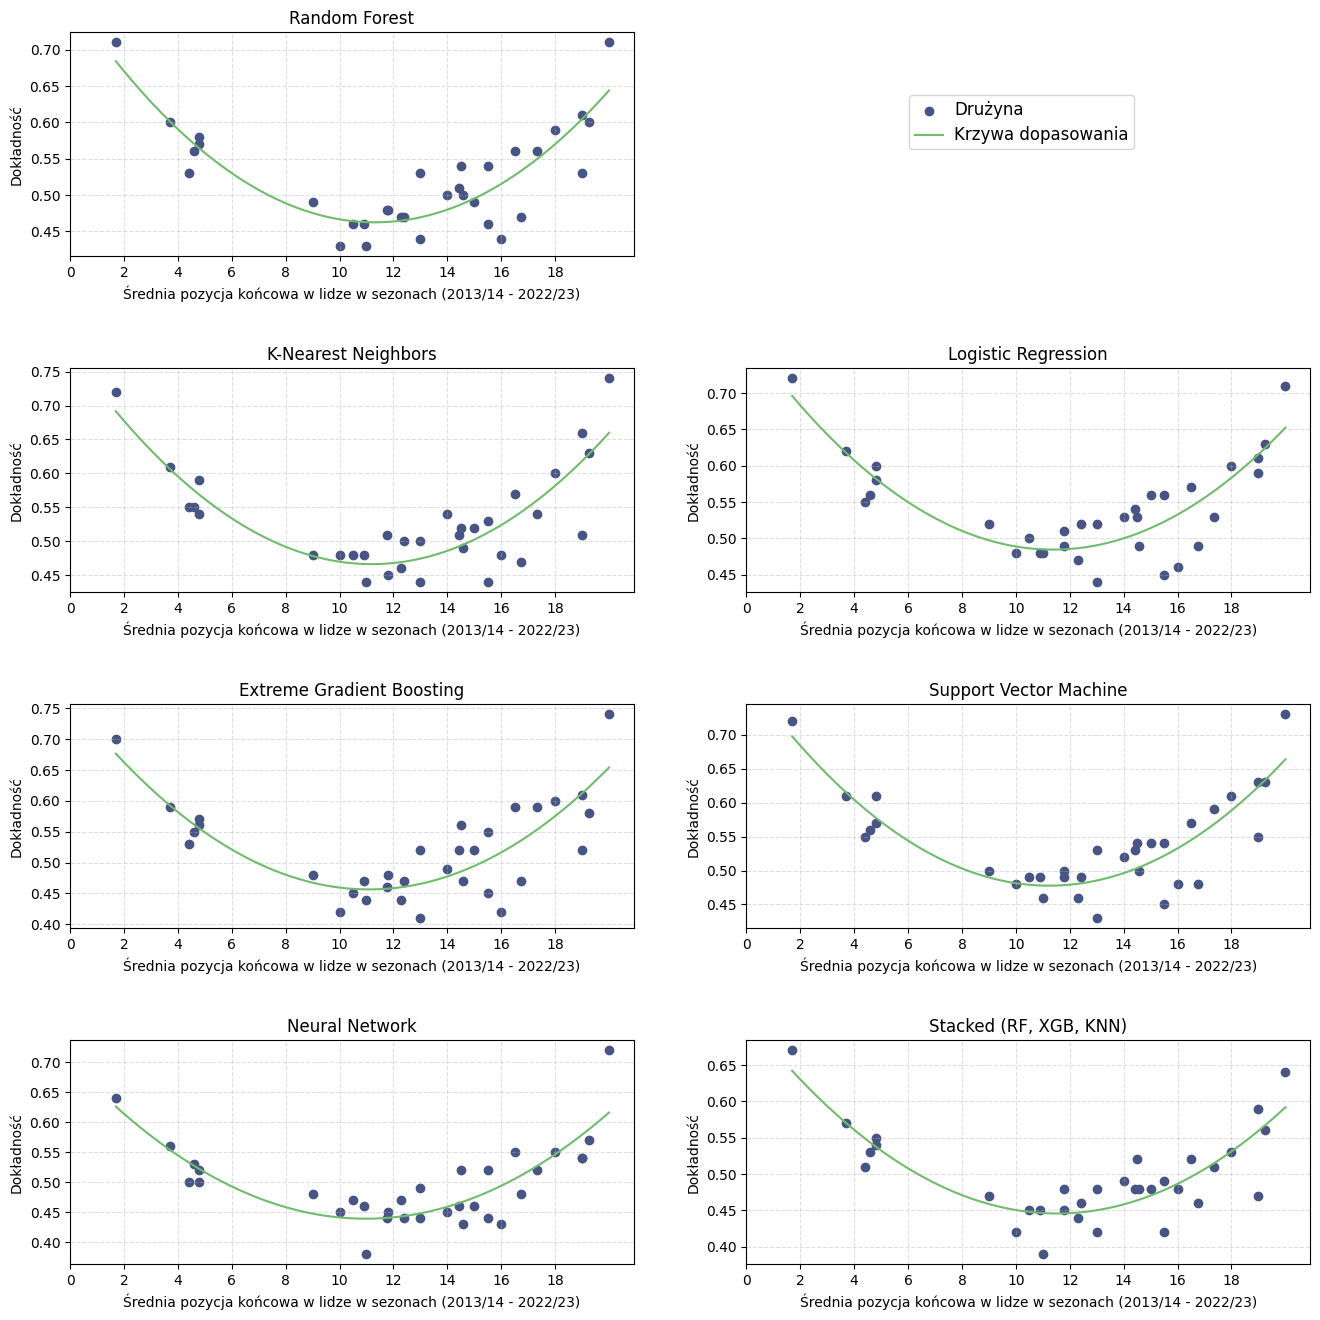

In [116]:
models = ['Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'Extreme Gradient Boosting', 
          'Support Vector Machine', 'Neural Network', 'Stacked (RF, XGB, KNN)']

def parabolic_func(x, a, b, c):
    return a * x**2 + b * x + c

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16), gridspec_kw={'hspace': 0.5})

for i, model in enumerate(models):
    if i != 0:  
        i+= 1
        
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    ax.scatter(merged_df['average_position'], merged_df[model], color=colors[0], label='Drużyna')
    
    x_data = merged_df['average_position']
    y_data = merged_df[model]
    popt, _ = curve_fit(parabolic_func, x_data, y_data)
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = parabolic_func(x_fit, *popt)
    ax.plot(x_fit, y_fit, color=colors[2], label='Krzywa dopasowania')
    
    ax.set_xlabel('Średnia pozycja końcowa w lidze w sezonach (2013/14 - 2022/23)')
    ax.set_ylabel('Dokładność')
    ax.set_title(model)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_xticks(np.arange(0, 20, 2))

axes[0, 1].remove()
plt.sca(axes[0, 0])
legend = plt.legend(bbox_to_anchor=(1.9, 0.75))
for text in legend.get_texts():
    text.set_fontsize(12)

plt.tight_layout()
plt.show()


***
Zbalansowany zbior treningowy (oversampling)

In [117]:
models = [rf, knn, lr, xgb, svc, nn, stacked]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Machine',
    'sequential': 'Neural Network',
    'stackingclassifier': 'Stacked (RF, XGB, KNN)'
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):
            
            class_counts = train['FTR'].value_counts()
            majority_class = class_counts.idxmax()

            balanced_train = pd.concat([
                resample(train[train['FTR'] == cls], 
                         replace=True,
                         n_samples=class_counts[majority_class],
                         random_state=42)
                for cls in class_counts.index
            ])

            X_train = balanced_train[predictors]
            y_train = balanced_train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.49333333333333335

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.45263157894736844

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.43466666666666665

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.42894736842105263

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.5081081081081081

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.4789473684210526

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.46842105263157896

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.4342105263157895

Training season/s: [2020]
Test season: [2021]
Accuracy: 0.42933333333333334

Training season/s: [2021]
Test season: [2022]
Accuracy: 0.432

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.432

Trai

Accuracy: 0.47733333333333333

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.48

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Extreme Gradient Boosting model on 2 season/s

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.45066666666666666

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.46842105263157896

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.42133333333333334

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.4342105263157895

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.4

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.4842105263157895

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.4710526315789474

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.4263157894736842

Training season/s: [2019, 2020]
Test season: [2021]
Accuracy: 0.44

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.4666666666666667

^v^v^v^v

Accuracy: 0.4746666666666667

Training season/s: [2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.432

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 3 season/s

Training season/s: [2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.288

Training season/s: [2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4394736842105263

Training season/s: [2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.408

Training season/s: [2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.3447368421052632

Training season/s: [2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.35405405405405405

Training season/s: [2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.44473684210526315

Training season/s: [2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4421052631578947

Training season/s: [2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.46842105263157896

Training season/s: [2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.416

Training season/s: [2019, 2020, 2021]
Test season: 

Accuracy: 0.4746666666666667

Training season/s: [2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4421052631578947

Training season/s: [2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.408

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4263157894736842

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4540540540540541

Training season/s: [2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.4473684210526316

Training season/s: [2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4394736842105263

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.3763157894736842

Training season/s: [2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.416

Training season/s: [2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.456

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 5 season/s

Training season/s: [2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accura

Accuracy: 0.416

Training season/s: [2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.44

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 6 season/s

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.49866666666666665

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.47368421052631576

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4266666666666667

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5157894736842106

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4972972972972973

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.48157894736842105

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.47368421052631576

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019]
Test sea

Accuracy: 0.512

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.46578947368421053

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.472

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5263157894736842

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5027027027027027

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5236842105263158

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.45

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4710526315789474

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.496

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.44533333333333336

^v^v^v^v^v^v^

Accuracy: 0.5013333333333333

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4921052631578947

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4533333333333333

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4789473684210526

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4864864864864865

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5078947368421053

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.48157894736842105

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4473684210526316

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5093333333333333

Training season/s: [2014,

Accuracy: 0.45263157894736844

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.42133333333333334

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.4186666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 9 season/s

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.49333333333333335

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4710526315789474

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.44533333333333336

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 201

Accuracy: 0.5066666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 9 season/s

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.4186666666666667

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4421052631578947

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.424

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5157894736842106

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4918918918918919

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.4868421052631579

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.43157894736842106

Training season/s:

Accuracy: 0.432

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.568

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5368421052631579

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.44533333333333336

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5210526315789473

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4972972972972973

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5578947368421052

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.48421052631578

In [118]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_oversampling_accuracies = pd.DataFrame(data).round(2)

df_oversampling_accuracies

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0            0.49                 0.43                 0.48   
1            0.45                 0.43                 0.48   
2            0.43                 0.38                 0.42   
3            0.43                 0.40                 0.49   
4            0.51                 0.43                 0.50   
..            ...                  ...                  ...   
95           0.52                 0.52                 0.53   
96           0.48                 0.43                 0.48   
97           0.43                 0.44                 0.48   
98           0.53                 0.43                 0.49   
99           0.45                 0.46                 0.49   

    Extreme Gradient Boosting  Support Vector Machine  Neural Network  \
0                        0.44                    0.50            0.54   
1                        0.44                    0.38            0.51   
2                        0.38                    0.42            0.54   
3                        0.38                    0.47            0.47   
4                        0.42                    0.49            0.51   
..                        ...                     ...             ...   
95                       0.53                    0.53            0.56   
96                       0.48                    0.47            0.48   
97                       0.42                    0.44            0.48   
98                       0.53                    0.49            0.53   
99                       0.43                    0.43            0.50   

    Stacked (RF, XGB, KNN)  
0                     0.41  
1                     0.46  
2                     0.38  
3                     0.36  
4                     0.44  
..                     ...  
95                    0.51  
96                    0.43  
97                    0.43  
98                    0.49  
99                    0.40  

[100 rows x 7 columns]

In [119]:
df_oversampling_accuracies.mean()

Random Forest                0.4752
K-Nearest Neighbors          0.4489
Logistic Regression          0.4936
Extreme Gradient Boosting    0.4482
Support Vector Machine       0.4711
Neural Network               0.4748
Stacked (RF, XGB, KNN)       0.4371
dtype: float64

In [120]:
df_oversampling_accuracies.max()

Random Forest                0.53
K-Nearest Neighbors          0.53
Logistic Regression          0.57
Extreme Gradient Boosting    0.53
Support Vector Machine       0.55
Neural Network               0.58
Stacked (RF, XGB, KNN)       0.52
dtype: float64

In [121]:
df_oversampling_accuracies.min()

Random Forest                0.42
K-Nearest Neighbors          0.38
Logistic Regression          0.42
Extreme Gradient Boosting    0.37
Support Vector Machine       0.38
Neural Network               0.23
Stacked (RF, XGB, KNN)       0.36
dtype: float64

In [122]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_oversampling_accuracies_mean = pd.DataFrame(data).round(3)

df_oversampling_accuracies_mean

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0          0.456                0.421                0.473   
1          0.479                0.438                0.490   
2          0.472                0.439                0.493   
3          0.472                0.459                0.499   
4          0.475                0.460                0.496   
5          0.471                0.456                0.498   
6          0.486                0.462                0.498   
7          0.483                0.454                0.495   
8          0.477                0.452                0.497   
9          0.477                0.454                0.498   

   Extreme Gradient Boosting  Support Vector Machine  Neural Network  \
0                      0.423                   0.451           0.496   
1                      0.446                   0.468           0.488   
2                      0.443                   0.457           0.393   
3                      0.447                   0.472           0.395   
4                      0.452                   0.484           0.456   
5                      0.447                   0.480           0.477   
6                      0.452                   0.477           0.501   
7                      0.452                   0.476           0.511   
8                      0.460                   0.475           0.516   
9                      0.462                   0.470           0.512   

   Stacked (RF, XGB, KNN)  
0                   0.419  
1                   0.441  
2                   0.427  
3                   0.434  
4                   0.444  
5                   0.440  
6                   0.437  
7                   0.433  
8                   0.447  
9                   0.447

In [123]:
df_oversampling_accuracies_mean = df_oversampling_accuracies_mean.T
df_oversampling_accuracies_mean

0      1      2      3      4      5      6  \
Random Forest              0.456  0.479  0.472  0.472  0.475  0.471  0.486   
K-Nearest Neighbors        0.421  0.438  0.439  0.459  0.460  0.456  0.462   
Logistic Regression        0.473  0.490  0.493  0.499  0.496  0.498  0.498   
Extreme Gradient Boosting  0.423  0.446  0.443  0.447  0.452  0.447  0.452   
Support Vector Machine     0.451  0.468  0.457  0.472  0.484  0.480  0.477   
Neural Network             0.496  0.488  0.393  0.395  0.456  0.477  0.501   
Stacked (RF, XGB, KNN)     0.419  0.441  0.427  0.434  0.444  0.440  0.437   

                               7      8      9  
Random Forest              0.483  0.477  0.477  
K-Nearest Neighbors        0.454  0.452  0.454  
Logistic Regression        0.495  0.497  0.498  
Extreme Gradient Boosting  0.452  0.460  0.462  
Support Vector Machine     0.476  0.475  0.470  
Neural Network             0.511  0.516  0.512  
Stacked (RF, XGB, KNN)     0.433  0.447  0.447

***
Zbalansowany zbior treningowy (undersampling)

In [124]:
models = [rf, knn, lr, xgb, svc, nn, stacked]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Machine',
    'sequential': 'Neural Network',
    'stackingclassifier': 'Stacked (RF, XGB, KNN)'
}

accuracies_full = {f'trained_on_{i}_seasons': [] for i in range(1,11)}

for key, value in sets.items():
    accuracies = {model_names[model.__class__.__name__.lower()]: [] for model in models}

    for model in models:
        
        i = int(re.findall(r'\d+', key)[0])
        
        print('^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on {i} season/s\n')
        
        for train, test in zip(value[0], value[1]):
            
            class_counts = train['FTR'].value_counts()
            minority_class = class_counts.idxmin()

            balanced_train = pd.concat([
                resample(train[train['FTR'] == cls], 
                         replace=False,
                         n_samples=class_counts[minority_class],
                         random_state=42)
                for cls in class_counts.index
            ])

            X_train = balanced_train[predictors]
            y_train = balanced_train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)

            accuracy = accuracy_score(y_test, preds)
            accuracies[model_names[model.__class__.__name__.lower()]].append(accuracy)
            
            print(f'Accuracy: {accuracy}\n')
            
    accuracies_full[key].append(accuracies)      

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.45866666666666667

Training season/s: [2013]
Test season: [2014]
Accuracy: 0.4789473684210526

Training season/s: [2014]
Test season: [2015]
Accuracy: 0.45866666666666667

Training season/s: [2015]
Test season: [2016]
Accuracy: 0.4263157894736842

Training season/s: [2016]
Test season: [2017]
Accuracy: 0.4783783783783784

Training season/s: [2017]
Test season: [2018]
Accuracy: 0.49736842105263157

Training season/s: [2018]
Test season: [2019]
Accuracy: 0.45

Training season/s: [2019]
Test season: [2020]
Accuracy: 0.4368421052631579

Training season/s: [2020]
Test season: [2021]
Accuracy: 0.424

Training season/s: [2021]
Test season: [2022]
Accuracy: 0.4

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 1 season/s

Training season/s: [2012]
Test season: [2013]
Accuracy: 0.4533333333333333

Training season/s: [201

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.43733333333333335

Training season/s: [2014, 2015]
Test season: [2016]
Accuracy: 0.4

Training season/s: [2015, 2016]
Test season: [2017]
Accuracy: 0.4486486486486487

Training season/s: [2016, 2017]
Test season: [2018]
Accuracy: 0.48947368421052634

Training season/s: [2017, 2018]
Test season: [2019]
Accuracy: 0.4631578947368421

Training season/s: [2018, 2019]
Test season: [2020]
Accuracy: 0.42105263157894735

Training season/s: [2019, 2020]
Test season: [2021]
Accuracy: 0.43733333333333335

Training season/s: [2020, 2021]
Test season: [2022]
Accuracy: 0.424

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Support Vector Machine model on 2 season/s

Training season/s: [2011, 2012]
Test season: [2013]
Accuracy: 0.5013333333333333

Training season/s: [2012, 2013]
Test season: [2014]
Accuracy: 0.4631578947368421

Training season/s: [2013, 2014]
Test season: [2015]
Accuracy: 0.416

Training season/s: [2014, 2015]
Test se

Accuracy: 0.41333333333333333

Training season/s: [2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.5289473684210526

Training season/s: [2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4666666666666667

Training season/s: [2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.5631578947368421

Training season/s: [2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5378378378378378

Training season/s: [2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5921052631578947

Training season/s: [2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.5026315789473684

Training season/s: [2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.48157894736842105

Training season/s: [2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5253333333333333

Training season/s: [2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.48

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 3 season/s

Training season/s: [2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.4746666666666667

Traini

Accuracy: 0.43466666666666665

Training season/s: [2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4105263157894737

Training season/s: [2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.42702702702702705

Training season/s: [2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.48157894736842105

Training season/s: [2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.45

Training season/s: [2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.45

Training season/s: [2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.424

Training season/s: [2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.4026666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 5 season/s

Training season/s: [2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.512

Training season/s: [2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4763157894736842

Training season/s: [2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accura

Accuracy: 0.5026315789473684

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.4026666666666667

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.49473684210526314

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.5135135135135135

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5157894736842106

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.46842105263157896

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.42894736842105263

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.4666666666666667

Training season/s: [2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.43733333333333335

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 6 season/s

Training season/s: [2007,

Accuracy: 0.5

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4631578947368421

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4421052631578947

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.45866666666666667

Training season/s: [2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.4026666666666667

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 7 season/s

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5066666666666667

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.46842105263157896

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.432

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4789473684210526

Trainin

Accuracy: 0.4810810810810811

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.48947368421052634

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.47368421052631576

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.46842105263157896

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.496

Training season/s: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.43466666666666665

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training K-Nearest Neighbors model on 8 season/s

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.47733333333333333

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.46578947368421053

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 20

Accuracy: 0.5066666666666667

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Accuracy: 0.4868421052631579

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Accuracy: 0.42933333333333334

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Accuracy: 0.4763157894736842

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4810810810810811

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5210526315789473

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.48947368421052634

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.45

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.50933333

Accuracy: 0.4631578947368421

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Accuracy: 0.4486486486486487

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.48157894736842105

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.4473684210526316

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.4

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.488

Training season/s: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.424

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.5226666666666666

Training season/s: [2004, 2005, 2006, 2007, 2008

Accuracy: 0.5108108108108108

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Accuracy: 0.5815789473684211

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Accuracy: 0.48947368421052634

Training season/s: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test season: [2020]
Accuracy: 0.5026315789473684

Training season/s: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Test season: [2021]
Accuracy: 0.5333333333333333

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Accuracy: 0.47733333333333333

^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Stacked (RF, XGB, KNN) model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Accuracy: 0.4266666666666667

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season

In [125]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).extend(accuracies_list)

df_undersampling_accuracies = pd.DataFrame(data).round(2)

df_undersampling_accuracies

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0            0.46                 0.45                 0.49   
1            0.48                 0.43                 0.48   
2            0.46                 0.40                 0.42   
3            0.43                 0.45                 0.47   
4            0.48                 0.42                 0.49   
..            ...                  ...                  ...   
95           0.50                 0.51                 0.54   
96           0.48                 0.48                 0.49   
97           0.44                 0.45                 0.46   
98           0.49                 0.48                 0.50   
99           0.43                 0.46                 0.49   

    Extreme Gradient Boosting  Support Vector Machine  Neural Network  \
0                        0.43                    0.41            0.58   
1                        0.41                    0.44            0.54   
2                        0.37                    0.41            0.49   
3                        0.43                    0.42            0.50   
4                        0.45                    0.50            0.49   
..                        ...                     ...             ...   
95                       0.52                    0.54            0.58   
96                       0.46                    0.47            0.49   
97                       0.44                    0.44            0.50   
98                       0.48                    0.49            0.53   
99                       0.46                    0.47            0.48   

    Stacked (RF, XGB, KNN)  
0                     0.39  
1                     0.41  
2                     0.38  
3                     0.39  
4                     0.46  
..                     ...  
95                    0.48  
96                    0.45  
97                    0.43  
98                    0.45  
99                    0.44  

[100 rows x 7 columns]

In [126]:
df_undersampling_accuracies.mean()

Random Forest                0.4700
K-Nearest Neighbors          0.4613
Logistic Regression          0.4980
Extreme Gradient Boosting    0.4548
Support Vector Machine       0.4741
Neural Network               0.5174
Stacked (RF, XGB, KNN)       0.4405
dtype: float64

In [127]:
df_undersampling_accuracies.max()

Random Forest                0.52
K-Nearest Neighbors          0.54
Logistic Regression          0.56
Extreme Gradient Boosting    0.54
Support Vector Machine       0.56
Neural Network               0.62
Stacked (RF, XGB, KNN)       0.52
dtype: float64

In [128]:
df_undersampling_accuracies.min()

Random Forest                0.40
K-Nearest Neighbors          0.38
Logistic Regression          0.42
Extreme Gradient Boosting    0.37
Support Vector Machine       0.41
Neural Network               0.40
Stacked (RF, XGB, KNN)       0.38
dtype: float64

In [129]:
data = {}

for season, models in accuracies_full.items():
    for model_data in models:
        for model, accuracies_list in model_data.items():
            data.setdefault(model, []).append(np.mean(accuracies_list))

df_undersampling_accuracies_mean = pd.DataFrame(data).round(3)

df_undersampling_accuracies_mean

Random Forest  K-Nearest Neighbors  Logistic Regression  \
0          0.451                0.436                0.478   
1          0.468                0.452                0.500   
2          0.469                0.450                0.500   
3          0.467                0.460                0.502   
4          0.472                0.456                0.497   
5          0.472                0.468                0.500   
6          0.465                0.474                0.503   
7          0.474                0.472                0.499   
8          0.483                0.473                0.502   
9          0.478                0.472                0.500   

   Extreme Gradient Boosting  Support Vector Machine  Neural Network  \
0                      0.424                   0.442           0.508   
1                      0.453                   0.473           0.517   
2                      0.450                   0.477           0.509   
3                      0.453                   0.477           0.497   
4                      0.437                   0.472           0.517   
5                      0.458                   0.478           0.530   
6                      0.462                   0.481           0.521   
7                      0.462                   0.477           0.525   
8                      0.485                   0.482           0.528   
9                      0.464                   0.483           0.526   

   Stacked (RF, XGB, KNN)  
0                   0.418  
1                   0.435  
2                   0.436  
3                   0.437  
4                   0.444  
5                   0.444  
6                   0.453  
7                   0.454  
8                   0.448  
9                   0.435

In [130]:
df_undersampling_accuracies_mean = df_undersampling_accuracies_mean.T
df_undersampling_accuracies_mean

0      1      2      3      4      5      6  \
Random Forest              0.451  0.468  0.469  0.467  0.472  0.472  0.465   
K-Nearest Neighbors        0.436  0.452  0.450  0.460  0.456  0.468  0.474   
Logistic Regression        0.478  0.500  0.500  0.502  0.497  0.500  0.503   
Extreme Gradient Boosting  0.424  0.453  0.450  0.453  0.437  0.458  0.462   
Support Vector Machine     0.442  0.473  0.477  0.477  0.472  0.478  0.481   
Neural Network             0.508  0.517  0.509  0.497  0.517  0.530  0.521   
Stacked (RF, XGB, KNN)     0.418  0.435  0.436  0.437  0.444  0.444  0.453   

                               7      8      9  
Random Forest              0.474  0.483  0.478  
K-Nearest Neighbors        0.472  0.473  0.472  
Logistic Regression        0.499  0.502  0.500  
Extreme Gradient Boosting  0.462  0.485  0.464  
Support Vector Machine     0.477  0.482  0.483  
Neural Network             0.525  0.528  0.526  
Stacked (RF, XGB, KNN)     0.454  0.448  0.435

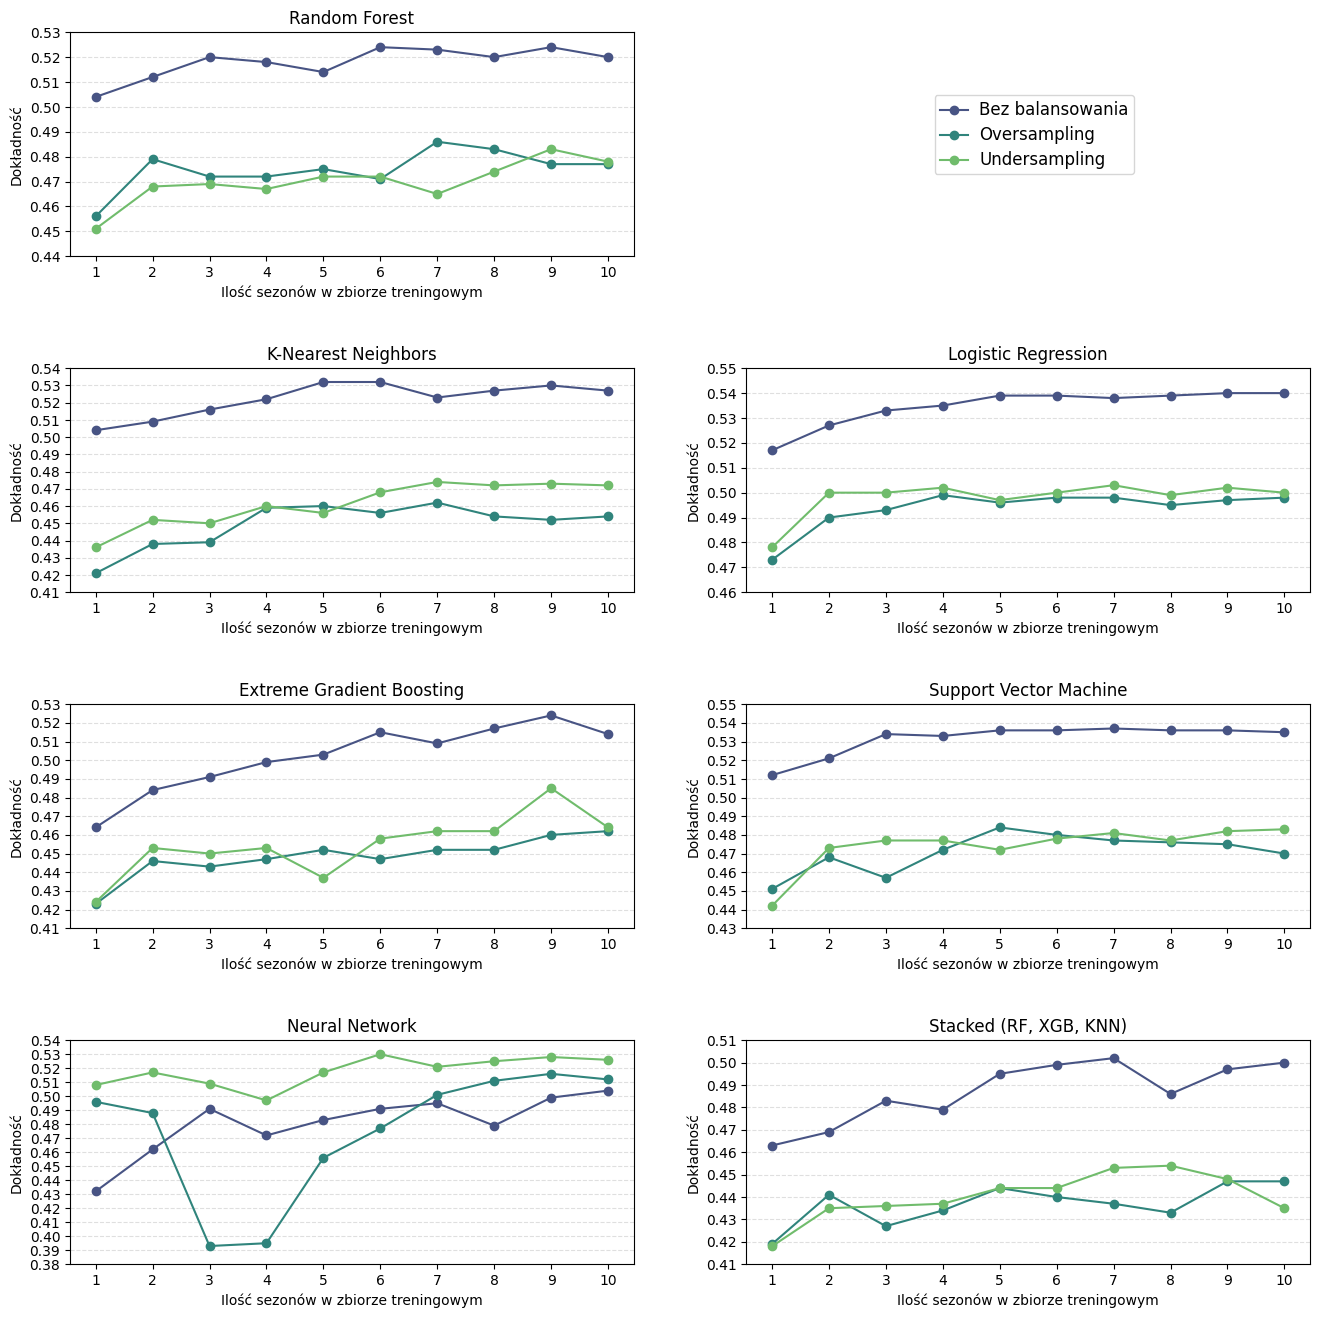

In [131]:
models = [
    'Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'Extreme Gradient Boosting', 
    'Support Vector Machine', 'Neural Network', 'Stacked (RF, XGB, KNN)'
]

colors = ['#485484', '#30847c', '#70bc6c']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16) , gridspec_kw={'hspace': 0.5})

for i, model in enumerate(models):
    if i != 0:  
        i+= 1
        
    row = i // 2
    col = i % 2
    
    plt.sca(axes[row, col])
    
    accuracies = df_accuracies_mean.loc[model]
    oversampling_accuracies = df_oversampling_accuracies_mean.loc[model]
    undersampling_accuracies = df_undersampling_accuracies_mean.loc[model]
    
    plt.plot(range(1, 11), accuracies, marker='o', label='Bez balansowania', color=colors[0])
    plt.plot(range(1, 11), oversampling_accuracies, marker='o', label='Oversampling', color=colors[1])
    plt.plot(range(1, 11), undersampling_accuracies, marker='o', label='Undersampling', color=colors[2])
    
    merged = []
    merged.extend(accuracies)
    merged.extend(oversampling_accuracies)
    merged.extend(undersampling_accuracies)
    
    min_y = round(min(merged), 2) - 0.01
    max_y = round(max(merged), 2) + 0.01
    
    plt.title(model)
    plt.xlabel('Ilość sezonów w zbiorze treningowym')
    plt.ylabel('Dokładność')
    plt.xticks(range(1, 11))
    plt.yticks(np.arange(min_y, max_y, 0.01))
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    
axes[0, 1].remove()
plt.sca(axes[0, 0])
legend = plt.legend(bbox_to_anchor=(1.9, 0.75))
for text in legend.get_texts():
    text.set_fontsize(12)

plt.tight_layout()
plt.show()

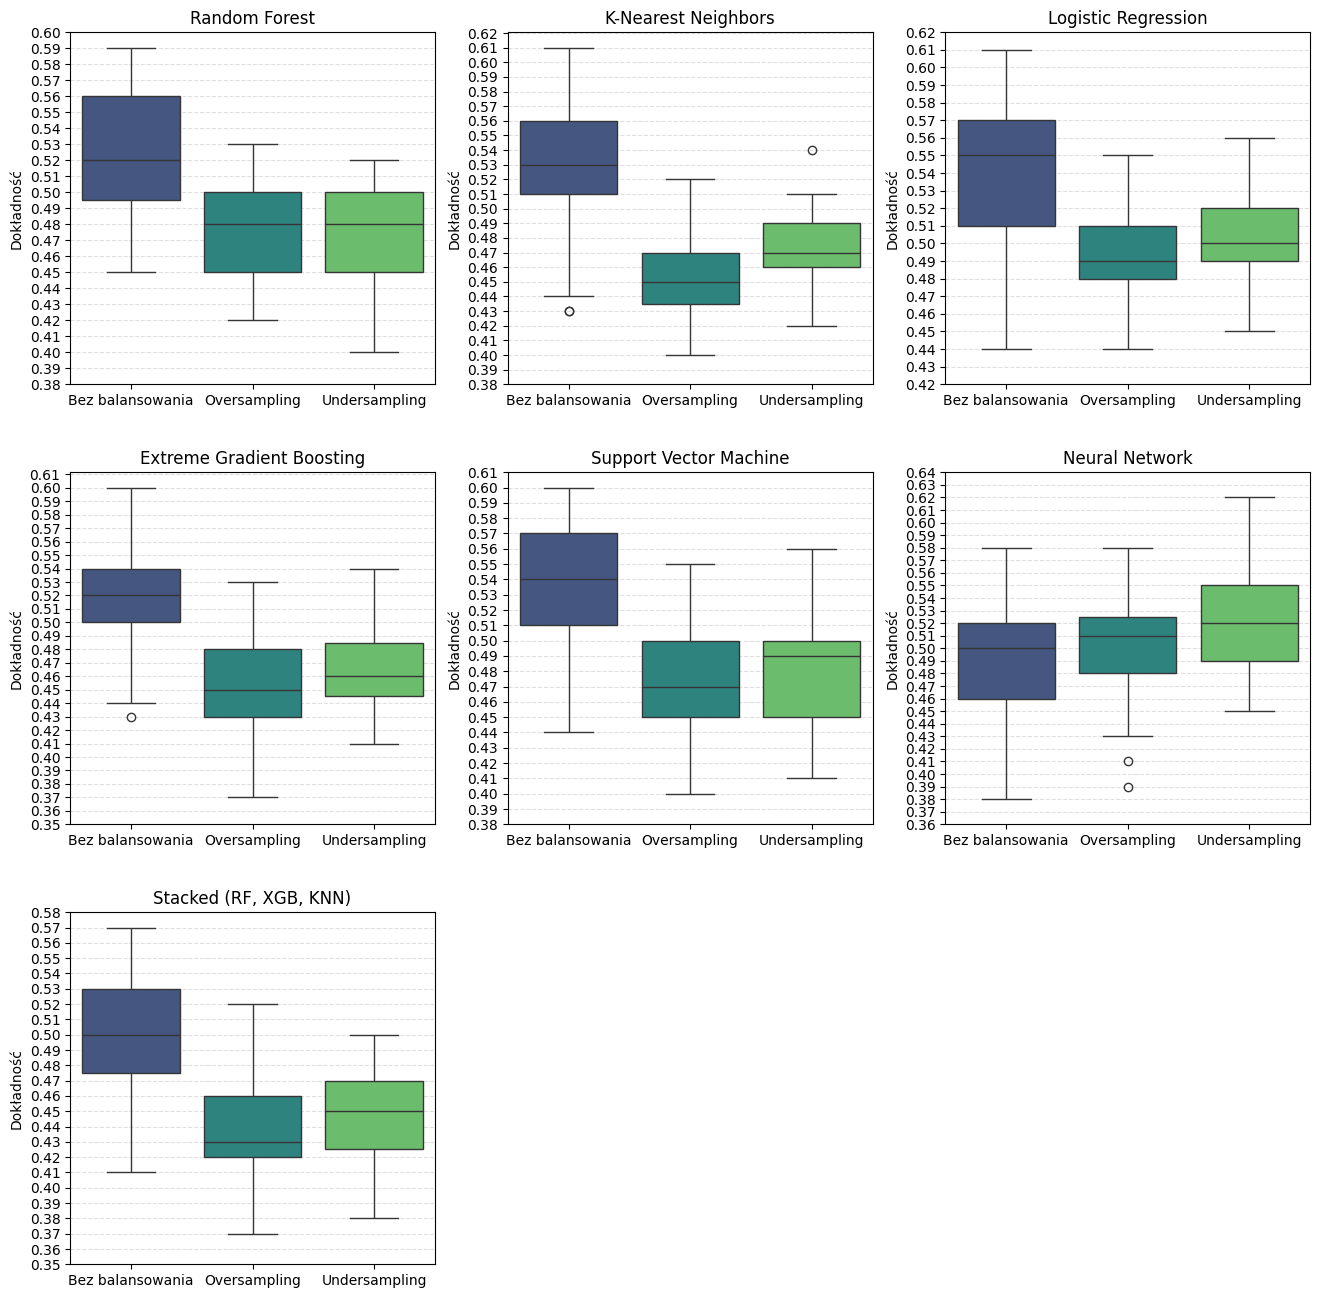

In [132]:
models = [
    'Random Forest', 'K-Nearest Neighbors', 'Logistic Regression', 'Extreme Gradient Boosting', 
    'Support Vector Machine', 'Neural Network', 'Stacked (RF, XGB, KNN)'
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 16) , gridspec_kw={'hspace': 0.25})

for i, model in enumerate(models):
    row = i // 3
    col = i % 3
    
    data = pd.concat([
        df_accuracies[model].iloc[49:], 
        df_oversampling_accuracies[model].iloc[49:], 
        df_undersampling_accuracies[model].iloc[49:]
    ], axis=1, keys=['Bez balansowania', 'Oversampling', 'Undersampling'])
    
    min_y = round(data.min().min(), 2) - 0.02
    max_y = round(data.max().max(), 2) + 0.02
    
    sns.boxplot(data=data, ax=axes[row, col], palette='viridis')
    axes[row, col].set_title(model)
    axes[row, col].set_ylabel('Dokładność')
    axes[row, col].set_xticklabels(['Bez balansowania', 'Oversampling', 'Undersampling'])
    axes[row, col].set_yticks(np.arange(min_y, max_y, 0.01))
    axes[row, col].grid(axis='y', linestyle='--', alpha=0.4)
    
axes[2, 1].remove()
axes[2, 2].remove()

plt.tight_layout()
plt.show()

In [137]:
nn_o = copy.deepcopy(nn)
nn_u = copy.deepcopy(nn)

models = [rf, knn, lr, xgb, svc, stacked, nn, nn_o, nn_u]

model_names = {
    'randomforestclassifier': 'Random Forest',
    'kneighborsclassifier': 'K-Nearest Neighbors',
    'logisticregression': 'Logistic Regression',
    'xgbclassifier': 'Extreme Gradient Boosting',
    'svc': 'Support Vector Machine',
    'stackingclassifier': 'Stacked (RF, XGB, KNN)',
    'sequential': 'Neural Network'
}

profit = {model_names[model] : [] for model in model_names}
profit['Neural Network (Oversampling)'] = []
profit['Neural Network (Undersampling)'] = []

correct_preds_odds = {model_names[model] : [] for model in model_names}
correct_preds_odds['Neural Network (Oversampling)'] = []
correct_preds_odds['Neural Network (Undersampling)'] = []

for model in models:
        
        print('\n^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v')
        print(f'Training {model_names[model.__class__.__name__.lower()]} model on 10 season/s\n')
        
        for train, test in zip(sets['trained_on_10_seasons'][0], sets['trained_on_10_seasons'][1]):
            
            season_profit = 0

            X_train = train[predictors]
            y_train = train['target']
            
            X_test = test[predictors]
            y_test = test['target']
            
            print(f'Training season/s: {pd.concat([train["season"]]).unique().tolist()}')
            print(f'Test season: {pd.concat([test["season"]]).unique().tolist()}')
            
            if model == nn:
                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)
            
            elif model == nn_o:
                class_counts = train['FTR'].value_counts()
                majority_class = class_counts.idxmax()

                balanced_train = pd.concat([
                    resample(train[train['FTR'] == cls], 
                             replace=True,
                             n_samples=class_counts[majority_class],
                             random_state=42)
                    for cls in class_counts.index
                ])

                X_train = balanced_train[predictors]
                y_train = balanced_train['target']

                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)
                
            elif model == nn_u:
                class_counts = train['FTR'].value_counts()
                minority_class = class_counts.idxmin()

                balanced_train = pd.concat([
                    resample(train[train['FTR'] == cls], 
                             replace=False,
                             n_samples=class_counts[minority_class],
                             random_state=42)
                    for cls in class_counts.index
                ])

                X_train = balanced_train[predictors]
                y_train = balanced_train['target']

                model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
                preds = model.predict(X_test, verbose=0)
                preds = np.argmax(preds, axis=1)
                
            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                
            for pred_label, actual_label, index in zip(preds, y_test, y_test.index):
                if pred_label == actual_label:
                    if pred_label == 0:
                        odds = df.loc[index, 'OH']
                        season_profit += ((1 * odds) - 1)
                    if pred_label == 1:
                        odds = df.loc[index, 'OD']
                        season_profit += ((1 * odds) - 1)
                    if pred_label == 2:
                        odds = df.loc[index, 'OA']
                        season_profit += ((1 * odds) - 1)
                        
                    if model == nn_o:
                        correct_preds_odds['Neural Network (Oversampling)'].append(odds)
                        
                    elif model == nn_u:
                        correct_preds_odds['Neural Network (Undersampling)'].append(odds)
                        
                    else:
                        correct_preds_odds[model_names[model.__class__.__name__.lower()]].append(odds)
                    
                else:
                    season_profit -= 1
                    
            season_profit = round(season_profit, 2)
            if model == nn_o:
                profit['Neural Network (Oversampling)'].append(season_profit)
                        
            elif model == nn_u:
                profit['Neural Network (Undersampling)'].append(season_profit)
                        
            else:
                profit[model_names[model.__class__.__name__.lower()]].append(season_profit)
            print(f'Profit this season: {season_profit} PLN\n')       


^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Random Forest model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Profit this season: 13.7 PLN

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Profit this season: -20.8 PLN

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Profit this season: -39.98 PLN

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Profit this season: 10.31 PLN

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Profit this season: -27.99 PLN

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2018]
Profit this season: 48.9 PLN

Training season/s: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Test season: [2019]
Profit this season: -8.46

Profit this season: -25.38 PLN

Training season/s: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Test season: [2022]
Profit this season: -8.2 PLN


^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v^v
Training Neural Network model on 10 season/s

Training season/s: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
Test season: [2013]
Profit this season: 42.08 PLN

Training season/s: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
Test season: [2014]
Profit this season: 5.0 PLN

Training season/s: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Test season: [2015]
Profit this season: 10.6 PLN

Training season/s: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
Test season: [2016]
Profit this season: 19.88 PLN

Training season/s: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test season: [2017]
Profit this season: -21.19 PLN

Training season/s: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Test season: [2

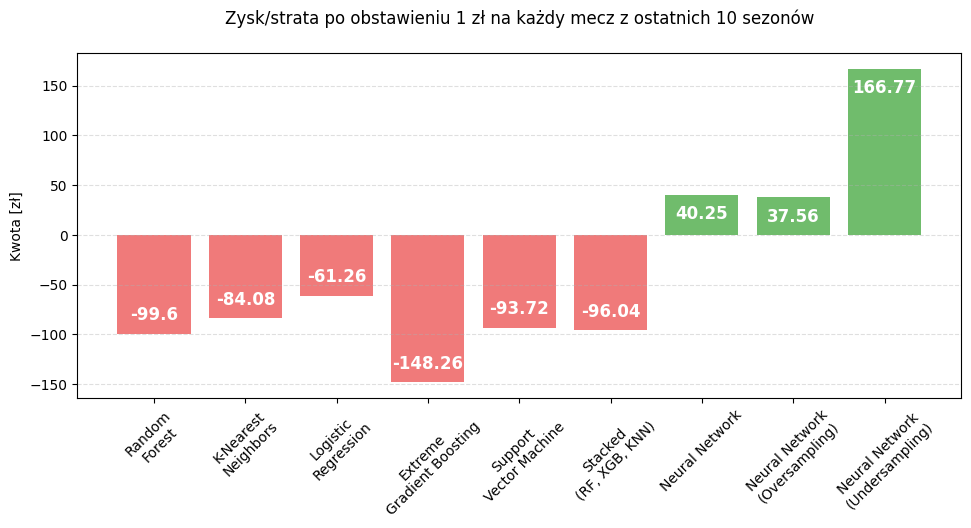

In [138]:
profit_sum = {model: round(sum(profit[model]), 2) for model in profit}

plt.figure(figsize=(10, 6))

bars = plt.bar(profit_sum.keys(), profit_sum.values(), 
               color=['#f07a7a' if value < 0 else colors[2] for value in profit_sum.values()])

plt.ylabel('Kwota [zł]')
plt.title('Zysk/strata po obstawieniu 1 zł na każdy mecz z ostatnich 10 sezonów\n')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)

custom_labels = [
    'Random\nForest', 'K-Nearest\nNeighbors', 'Logistic\nRegression', 'Extreme\nGradient Boosting', 
    'Support\nVector Machine', 'Stacked\n(RF, XGB, KNN)', 'Neural Network',
    'Neural Network\n(Oversampling)', 'Neural Network\n(Undersampling)'
]
plt.gca().set_xticklabels(custom_labels)

for bar, value in zip(bars, profit_sum.values()):
    if value < 0:
        va = 'bottom'
        y_pos = bar.get_height() + 10
    else:
        va = 'top'
        y_pos = bar.get_height() - 10
    
    plt.text(bar.get_x() + bar.get_width() / 2, 
             y_pos, 
             round(value, 2), 
             ha='center', 
             va=va, 
             color='white',
             weight='bold',
             fontsize=12)

plt.show()

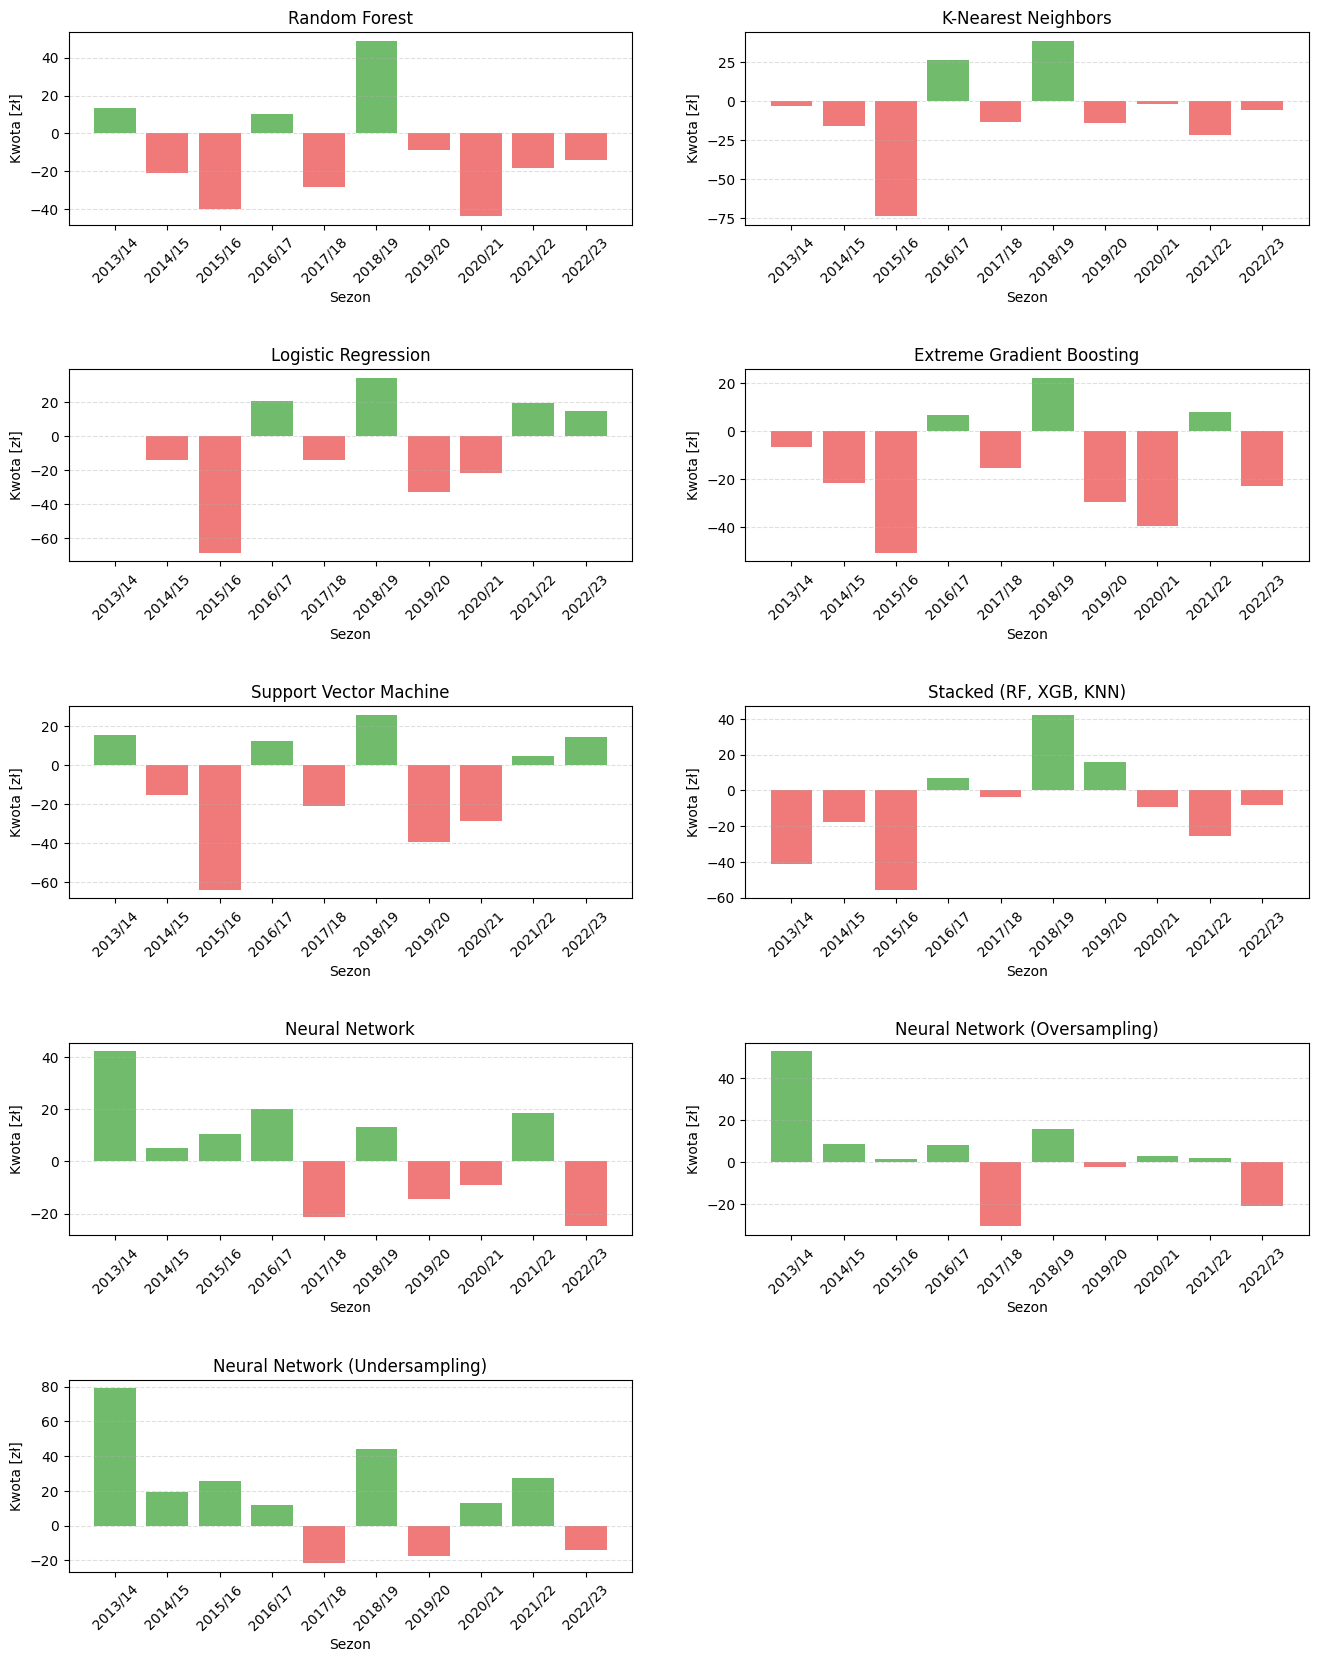

In [139]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20) , gridspec_kw={'hspace': 0.75})

for i, (model, values) in enumerate(profit.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    ax.bar(range(2013, 2023), values, color=['#f07a7a' if value < 0 else colors[2] for value in values])
    ax.set_title(model)
    ax.set_xlabel('Sezon')
    ax.set_ylabel('Kwota [zł]')
    ax.set_xticks(range(2013, 2023))
    ax.set_xticklabels(['2013/14', '2014/15', '2015/16', '2016/17', '2017/18', '2018/19', '2019/20',
                   '2020/21', '2021/22', '2022/23'], rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

axes[4, 1].remove()
    
plt.tight_layout()
plt.show()

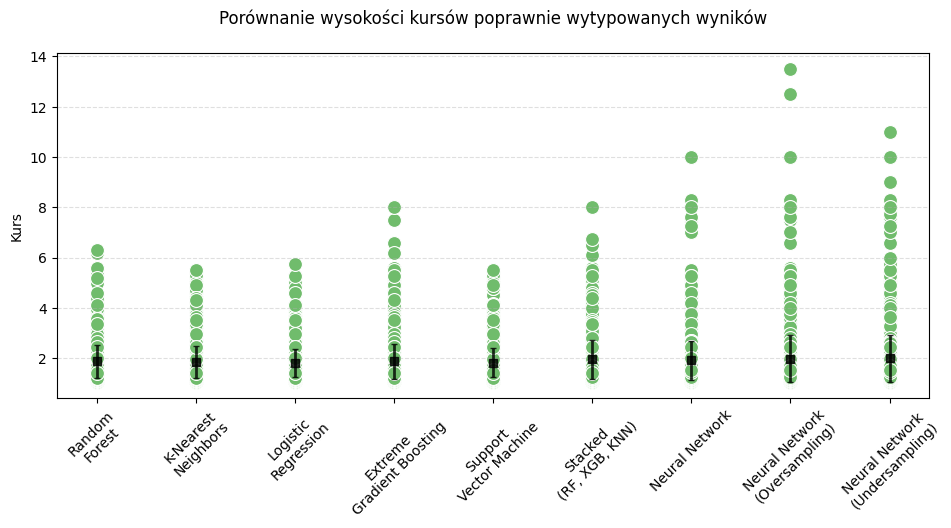

In [142]:
plt.figure(figsize=(10, 6))

max_length = max(len(v) for v in correct_preds_odds.values())
filled_correct_preds_odds = {k: v + [float('nan')] * (max_length - len(v)) for k, v in correct_preds_odds.items()}

odds_df = pd.DataFrame(filled_correct_preds_odds)
melted_df = odds_df.melt(var_name='model', value_name='odds')

scatterplot = sns.scatterplot(data=melted_df, x='model', y='odds', color=colors[2], s=100)

mean_std_by_model = melted_df.groupby('model')['odds'].agg(['mean', 'std']).reset_index()
for i, row in mean_std_by_model.iterrows():
    plt.errorbar(x=row['model'], y=row['mean'], yerr=row['std'], fmt='s', 
                 color='black', capsize=2, elinewidth=2, alpha=0.8)

plt.title('Porównanie wysokości kursów poprawnie wytypowanych wyników\n')
plt.ylabel('Kurs')
plt.xlabel('')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

custom_labels = [
    'Random\nForest', 'K-Nearest\nNeighbors', 'Logistic\nRegression', 'Extreme\nGradient Boosting', 
    'Support\nVector Machine', 'Stacked\n(RF, XGB, KNN)', 'Neural Network',
    'Neural Network\n(Oversampling)', 'Neural Network\n(Undersampling)'
]
plt.gca().set_xticklabels(custom_labels)

plt.show()